# Mengenalisis Interaction Network dari Data Twitter

### Persiapan Data

In [1]:
pip install networkx==2.3

Note: you may need to restart the kernel to use updated packages.


**Proses install Library PyMysql**

In [2]:
!pip install pymysql
!pip install mysql-connector-python-rf

**Melakukan import libraries**

In [3]:
#Import modules
%matplotlib inline

#handling data
#import libraries
import pandas as pd
import numpy as np
import glob
import json
import random
import collections
from operator import itemgetter
from networkx.readwrite import json_graph
from scipy import stats

#handling information
import re
import json

#handling plots
import matplotlib.pyplot as plt
import seaborn as sns

#for network creation
import networkx as nx

**Melakukan import data file CSV**

Deklarasi date_start dan date_end untuk masing-masing periode sebelum dan saat COVID-19 memetakan label setiap periodenya

In [6]:
from datetime import date

date_start = date(2019,12,13)
date_end   = date(2020,6,13)

date_start_convert = date_start.strftime('%d%m%Y')
date_end_convert = date_end.strftime('%d%m%Y')

Lakukan import file CSV yang berisi data tabel retweets, reply_to dan mentions

In [59]:
#membaca data pengguna
users_df = pd.read_csv('../data/interractions/all/users_data_after_joining_{}-{}.csv'.format(date_start_convert, date_end_convert))

#membaca data tabel interaksi mentions
final_mentions = pd.read_csv('../data/interractions/all/mentions_interractions_data_{}-{}.csv'.format(date_start_convert, date_end_convert))
final_mentions.set_index('username', inplace = True)

#membaca data tabel interaksi retweets
final_retweets = pd.read_csv('../data/interractions/all/retweets_interractions_data_{}-{}.csv'.format(date_start_convert, date_end_convert))
final_retweets.set_index('username', inplace = True)

#membaca data tabel interaksi reply_to
final_replyto = pd.read_csv('../data/interractions/all/replyto_interractions_data_{}-{}.csv'.format(date_start_convert, date_end_convert))
final_replyto.set_index('username', inplace = True)

#membaca data tabel interaksi perminggu
final_week_tweets = pd.read_csv('../data/interractions/all/week_tweets_data_{}-{}.csv'.format(date_start_convert, date_end_convert))
final_week_tweets.set_index('username', inplace = True)

#membaca data tabel interaksi perbulan
final_month_tweets = pd.read_csv('../data/interractions/all/month_tweets_data_{}-{}.csv'.format(date_start_convert, date_end_convert))
final_month_tweets.set_index('username', inplace = True)

## Membuat Graph dari Tabel Data Interaksi

**Keseluruhan Graph Interaksi dari Pengguna**

Membuat fungsi diskritisasi untuk mengecilkan nilai edges

In [4]:
def discretization_weight(edge_weight):
    size = []
    
    for i in edge_weight:
        if i > 10 and i < 25:
            size.append(1)
        elif i > 25 and i < 50:
            size.append(2)
        elif i > 50 and i < 75:
            size.append(3)
        elif i > 75 and i < 100:
            size.append(4)
        elif i > 100 and i < 150:
            size.append(5)
        elif i > 150 and i < 200:
            size.append(6)
        elif i > 200 and i < 250:
            size.append(7)
        elif i > 250 and i < 500:
            size.append(8)
        elif i > 500 and i < 1000:
            size.append(9)
        else:
            size.append(10)
    
    return size

Membuat graph untuk memetakan keseluruhan interaksi mentions pada pengguna

In [27]:
import networkx as nx
graph_data = nx.Graph()

for i, user in users_df.iterrows():
    for j, mentions in users_df.iterrows():
        mentions_data = final_mentions.loc[[user['username']], [mentions['username']]]
        mentions_value = mentions_data[mentions['username']][0]
        #check jika kedua user punya interaksi mentions
        if mentions_value > 0:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != mentions['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], mentions['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][mentions['username']]['color'] != 'green':
                            graph_data.add_node(user['username'], weight=mentions_value, color='#7FFFD4')
                            graph_data.add_node(mentions['username'], weight=mentions_value, color='#7FFFD4')
                            graph_data.add_edge(user['username'],mentions['username'], weight=mentions_value, color='green')
                else:
                    graph_data.add_node(user['username'], weight=mentions_value, color='#7FFFD4')
                    graph_data.add_node(mentions['username'], weight=mentions_value, color='#7FFFD4')
                    graph_data.add_edge(user['username'],mentions['username'], weight=mentions_value, color='green')

Membuat tambahan edge graph untuk memetakan interaksi retweet pada pengguna

In [28]:
for i, user in users_df.iterrows():
    for j, retweets in users_df.iterrows():
        retweets_data = final_retweets.loc[[user['username']], [retweets['username']]]
        retweets_value = retweets_data[retweets['username']][0]
        #check jika kedua user punya interaksi mentions
        if retweets_value > 0:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != retweets['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], retweets['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][retweets['username']]['color'] != 'blue' or graph_data[user['username']][retweets['username']]['color'] != 'green':
                            graph_data.add_node(user['username'], weight=retweets_value, color='#00BFFF')
                            graph_data.add_node(retweets['username'], weight=retweets_value, color='#00BFFF')
                            graph_data.add_edge(user['username'],retweets['username'], weight=retweets_value, color='blue')
                else:
                    graph_data.add_node(user['username'], weight=retweets_value, color='#00BFFF')
                    graph_data.add_node(retweets['username'], weight=retweets_value, color='#00BFFF')
                    graph_data.add_edge(user['username'],retweets['username'], weight=retweets_value, color='blue')

Membuat tambahan edge graph untuk memetakan interaksi reply_to pada pengguna

In [29]:
for i, user in users_df.iterrows():
    for j, replyto in users_df.iterrows():
        replyto_data = final_replyto.loc[[user['username']], [replyto['username']]]
        replyto_value = replyto_data[replyto['username']][0]
        #check jika kedua user punya interaksi mentions
        if replyto_value > 0:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != replyto['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], replyto['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][replyto['username']]['color'] != 'blue' or graph_data[user['username']][replyto['username']]['color'] != 'green' or graph_data[user['username']][replyto['username']]['color'] != 'red':
                            graph_data.add_node(user['username'], weight=replyto_value, color='#FF1493')
                            graph_data.add_node(replyto['username'], weight=replyto_value, color='#FF1493')
                            graph_data.add_edge(user['username'],replyto['username'], weight=replyto_value, color='red')
                else:
                    graph_data.add_node(user['username'], weight=replyto_value, color='#FF1493')
                    graph_data.add_node(replyto['username'], weight=replyto_value, color='#FF1493')
                    graph_data.add_edge(user['username'],replyto['username'], weight=replyto_value, color='red')

Menyalin nilai data graph

In [30]:
all_graph = graph_data.copy()

Menyimpan data graph ke file graphml

In [31]:
nx.write_graphml(all_graph, "../data/interractions/all/all_graph_data_before_diferencing_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [8]:
all_graph = nx.read_graphml("../data/interractions/all/all_graph_data_before_diferencing_{}-{}.graphml".format(date_start_convert, date_end_convert))  

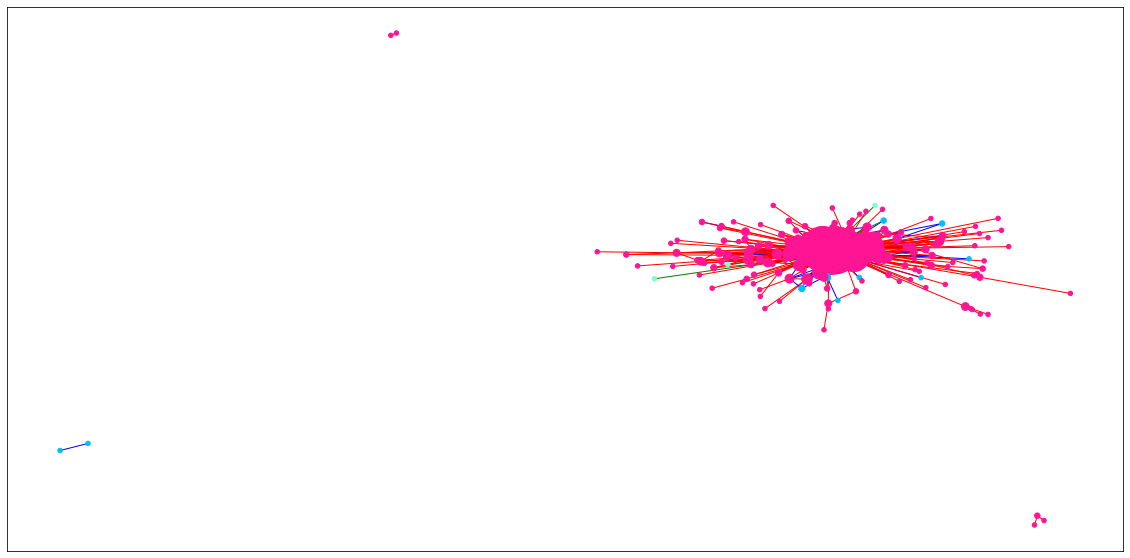

In [10]:
plt.figure(figsize=(20,10))
pos = nx.spring_layout(all_graph)
degrees = nx.degree(all_graph)
node_color = [all_graph.node[node]['color'] for node in all_graph]
node_size = [(degrees[v] + 1) * 10.0 for v in all_graph.nodes()]
edge_color = [all_graph[u][v]['color'] for u,v in all_graph.edges()]
#edge_weight = [all_graph[u][v]['weight'] for u,v in all_graph.edges()]
#edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(all_graph, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, with_labels=False)

**Keseluruhan Graph Interaksi dari Pengguna berdasarkan nilai Thresold 10**

Membuat graph untuk memetakan keseluruhan interaksi mentions pada pengguna

In [175]:
import networkx as nx
graph_data = nx.Graph()

for i, user in users_df.iterrows():
    for j, mentions in users_df.iterrows():
        mentions_data = final_mentions.loc[[user['username']], [mentions['username']]]
        mentions_value = mentions_data[mentions['username']][0]
        #check jika kedua user punya interaksi mentions
        if mentions_value > 10:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != mentions['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], mentions['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][mentions['username']]['color'] != 'green':
                            graph_data.add_node(user['username'], weight=mentions_value, color='#7FFFD4')
                            graph_data.add_node(mentions['username'], weight=mentions_value, color='#7FFFD4')
                            graph_data.add_edge(user['username'],mentions['username'], weight=mentions_value, color='green')
                else:
                    graph_data.add_node(user['username'], weight=mentions_value, color='#7FFFD4')
                    graph_data.add_node(mentions['username'], weight=mentions_value, color='#7FFFD4')
                    graph_data.add_edge(user['username'],mentions['username'], weight=mentions_value, color='green')

Menyalin nilai mentions graph

In [177]:
mentions_graph_data = graph_data.copy()

Menyimpan data graph ke file graphml

In [229]:
nx.write_graphml(mentions_graph_data, "../data/interractions/all/mentions_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [11]:
mentions_graph_data = nx.read_graphml("../data/interractions/all/mentions_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

Menampikan graph dari aktivitas mentions

/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


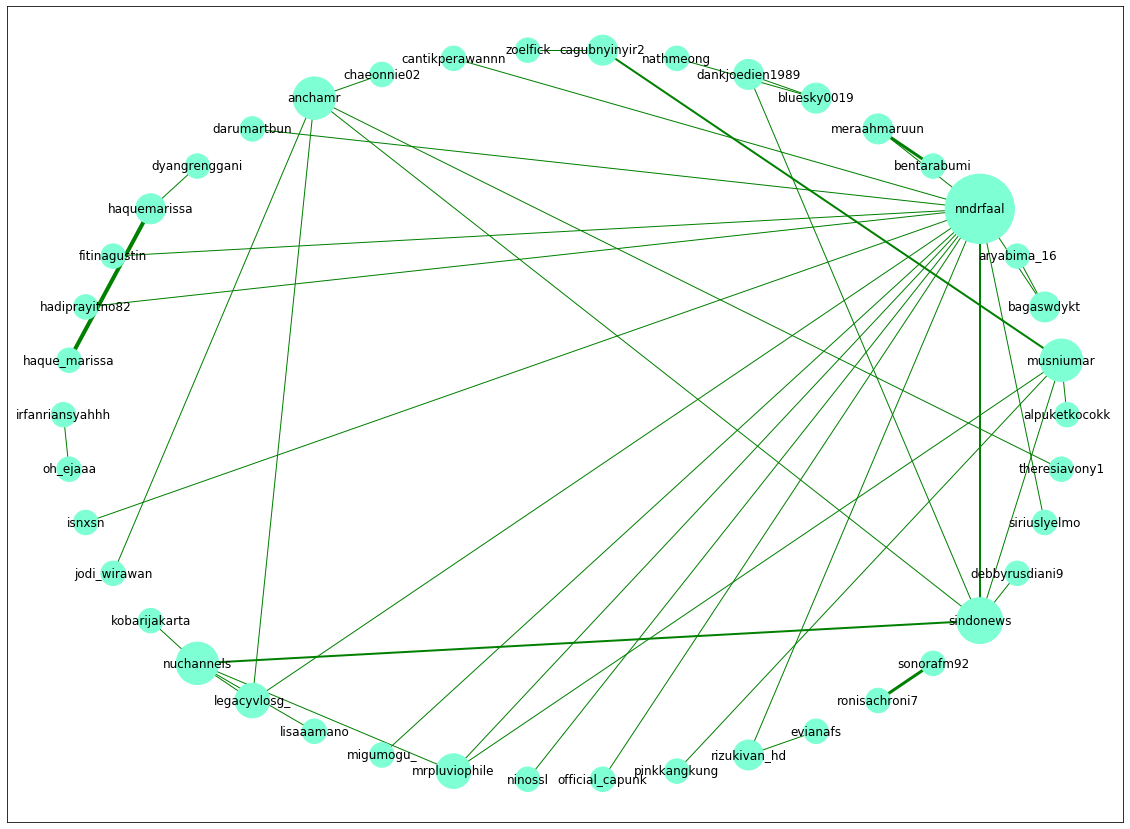

In [60]:
plt.figure(figsize=(20,15))
pos = nx.circular_layout(mentions_graph_data)
degrees = nx.degree(mentions_graph_data)
node_color = [mentions_graph_data.node[node]['color'] for node in mentions_graph_data]
node_size = [(degrees[v] + 1) * 300.0 for v in mentions_graph_data.nodes()]
edge_color = [mentions_graph_data[u][v]['color'] for u,v in mentions_graph_data.edges()]
edge_weight = [mentions_graph_data[u][v]['weight'] for u,v in mentions_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(mentions_graph_data, pos=pos, cmap=plt.cm.PiYG, node_color='#7FFFD4', node_size=node_size, edge_color=edge_color, width=edge_discretization)

Menampilkan 5 node dengan nilai degree terbesar

In [61]:
sorted(mentions_graph_data.degree, key=lambda x: x[1], reverse=True)[:5]

[('nndrfaal', 15),
 ('sindonews', 6),
 ('musniumar', 5),
 ('anchamr', 5),
 ('nuchannels', 5)]

Menampilkan graph untuk memetakan interaksi retweet pada pengguna

In [182]:
graph_data = nx.Graph()

for i, user in users_df.iterrows():
    for j, retweets in users_df.iterrows():
        retweets_data = final_retweets.loc[[user['username']], [retweets['username']]]
        retweets_value = retweets_data[retweets['username']][0]
        #check jika kedua user punya interaksi mentions
        if retweets_value > 10:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != retweets['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], retweets['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][retweets['username']]['color'] != 'blue' or graph_data[user['username']][retweets['username']]['color'] != 'green':
                            graph_data.add_node(user['username'], weight=retweets_value, color='#00BFFF')
                            graph_data.add_node(retweets['username'], weight=retweets_value, color='#00BFFF')
                            graph_data.add_edge(user['username'],retweets['username'], weight=retweets_value, color='blue')
                else:
                    graph_data.add_node(user['username'], weight=retweets_value, color='#00BFFF')
                    graph_data.add_node(retweets['username'], weight=retweets_value, color='#00BFFF')
                    graph_data.add_edge(user['username'],retweets['username'], weight=retweets_value, color='blue')

Menyalin nilai retweets graph

In [183]:
retweets_graph_data = graph_data.copy()

Menyimpan data ke file graphml

In [239]:
nx.write_graphml(retweets_graph_data, "../data/interractions/all/retweets_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [12]:
retweets_graph_data = nx.read_graphml("../data/interractions/all/retweets_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

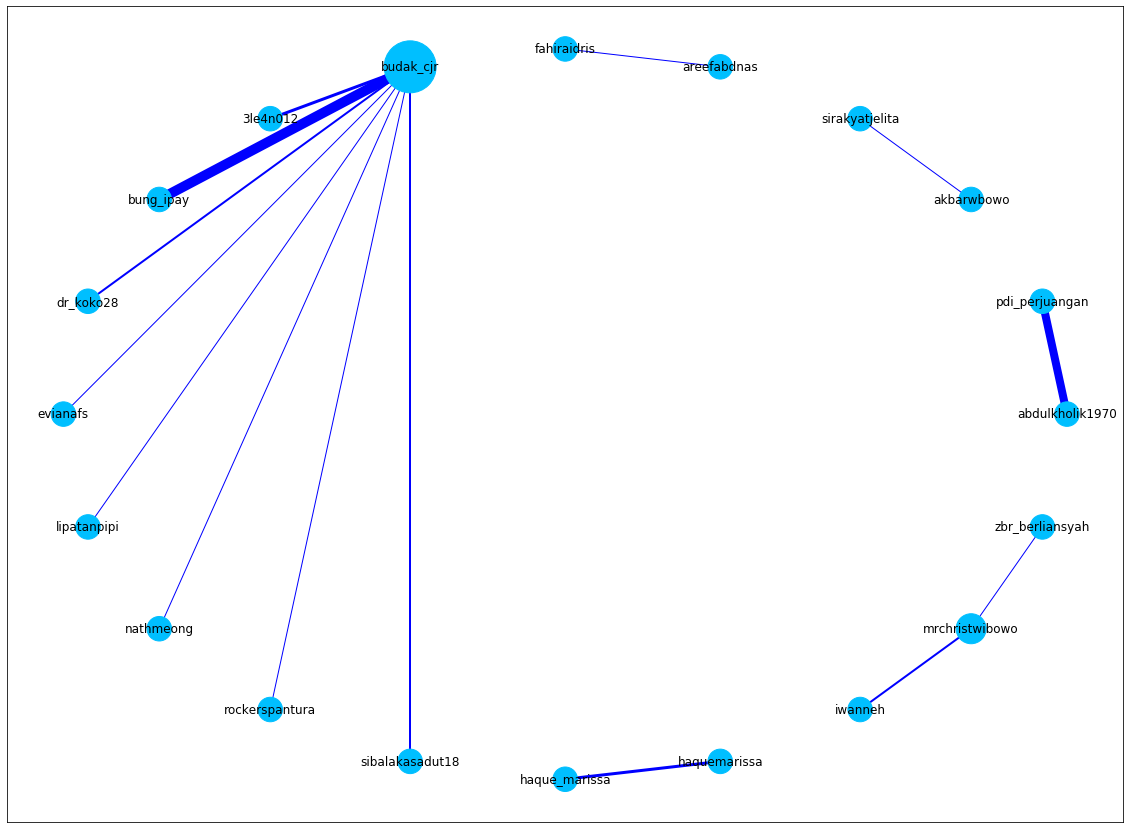

In [63]:
plt.figure(figsize=(20,15))
pos = nx.circular_layout(retweets_graph_data)
degrees = nx.degree(retweets_graph_data)
node_color = [retweets_graph_data.node[node]['color'] for node in retweets_graph_data]
node_size = [(degrees[v] + 1) * 300.0 for v in retweets_graph_data.nodes()]
edge_color = [retweets_graph_data[u][v]['color'] for u,v in retweets_graph_data.edges()]
edge_weight = [retweets_graph_data[u][v]['weight'] for u,v in retweets_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(retweets_graph_data, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)

Menampilkan 5 node dengan nilai degree terbesar

In [64]:
sorted(retweets_graph_data.degree, key=lambda x: x[1], reverse=True)[:5]

[('budak_cjr', 8),
 ('mrchristwibowo', 2),
 ('abdulkholik1970', 1),
 ('pdi_perjuangan', 1),
 ('akbarwbowo', 1)]

Menampilkan graph untuk memetakan interaksi reply_to pada pengguna

In [272]:
graph_data = nx.Graph()

for i, user in users_df.iterrows():
    for j, replyto in users_df.iterrows():
        replyto_data = final_replyto.loc[[user['username']], [replyto['username']]]
        replyto_value = replyto_data[replyto['username']][0]
        #check jika kedua user punya interaksi mentions
        if replyto_value > 50:
            #check agar user tidak berinteraksi mentions dengan dirinya sendiri
            if user['username'] != replyto['username']:
                #check jika edge kedua user belum ada
                check_edge = graph_data.get_edge_data(user['username'], replyto['username'], default=0)
                if check_edge != 0:
                    #check apakah warna edge nya hitam
                    if graph_data[user['username']][replyto['username']]['color'] != 'blue' or graph_data[user['username']][replyto['username']]['color'] != 'green' or graph_data[user['username']][replyto['username']]['color'] != 'red':
                            graph_data.add_node(user['username'], weight=replyto_value, color='#FF1493')
                            graph_data.add_node(replyto['username'], weight=replyto_value, color='#FF1493')
                            graph_data.add_edge(user['username'],replyto['username'], weight=replyto_value, color='red')
                else:
                    graph_data.add_node(user['username'], weight=replyto_value, color='#FF1493')
                    graph_data.add_node(replyto['username'], weight=replyto_value, color='#FF1493')
                    graph_data.add_edge(user['username'],replyto['username'], weight=replyto_value, color='red')

Menyalin nilai retweets graph

In [275]:
replyto_graph_data = graph_data.copy()

Menyimpan data ke file graphml

In [276]:
nx.write_graphml(replyto_graph_data, "../data/interractions/all/replyto_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [13]:
replyto_graph_data = nx.read_graphml("../data/interractions/all/replyto_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

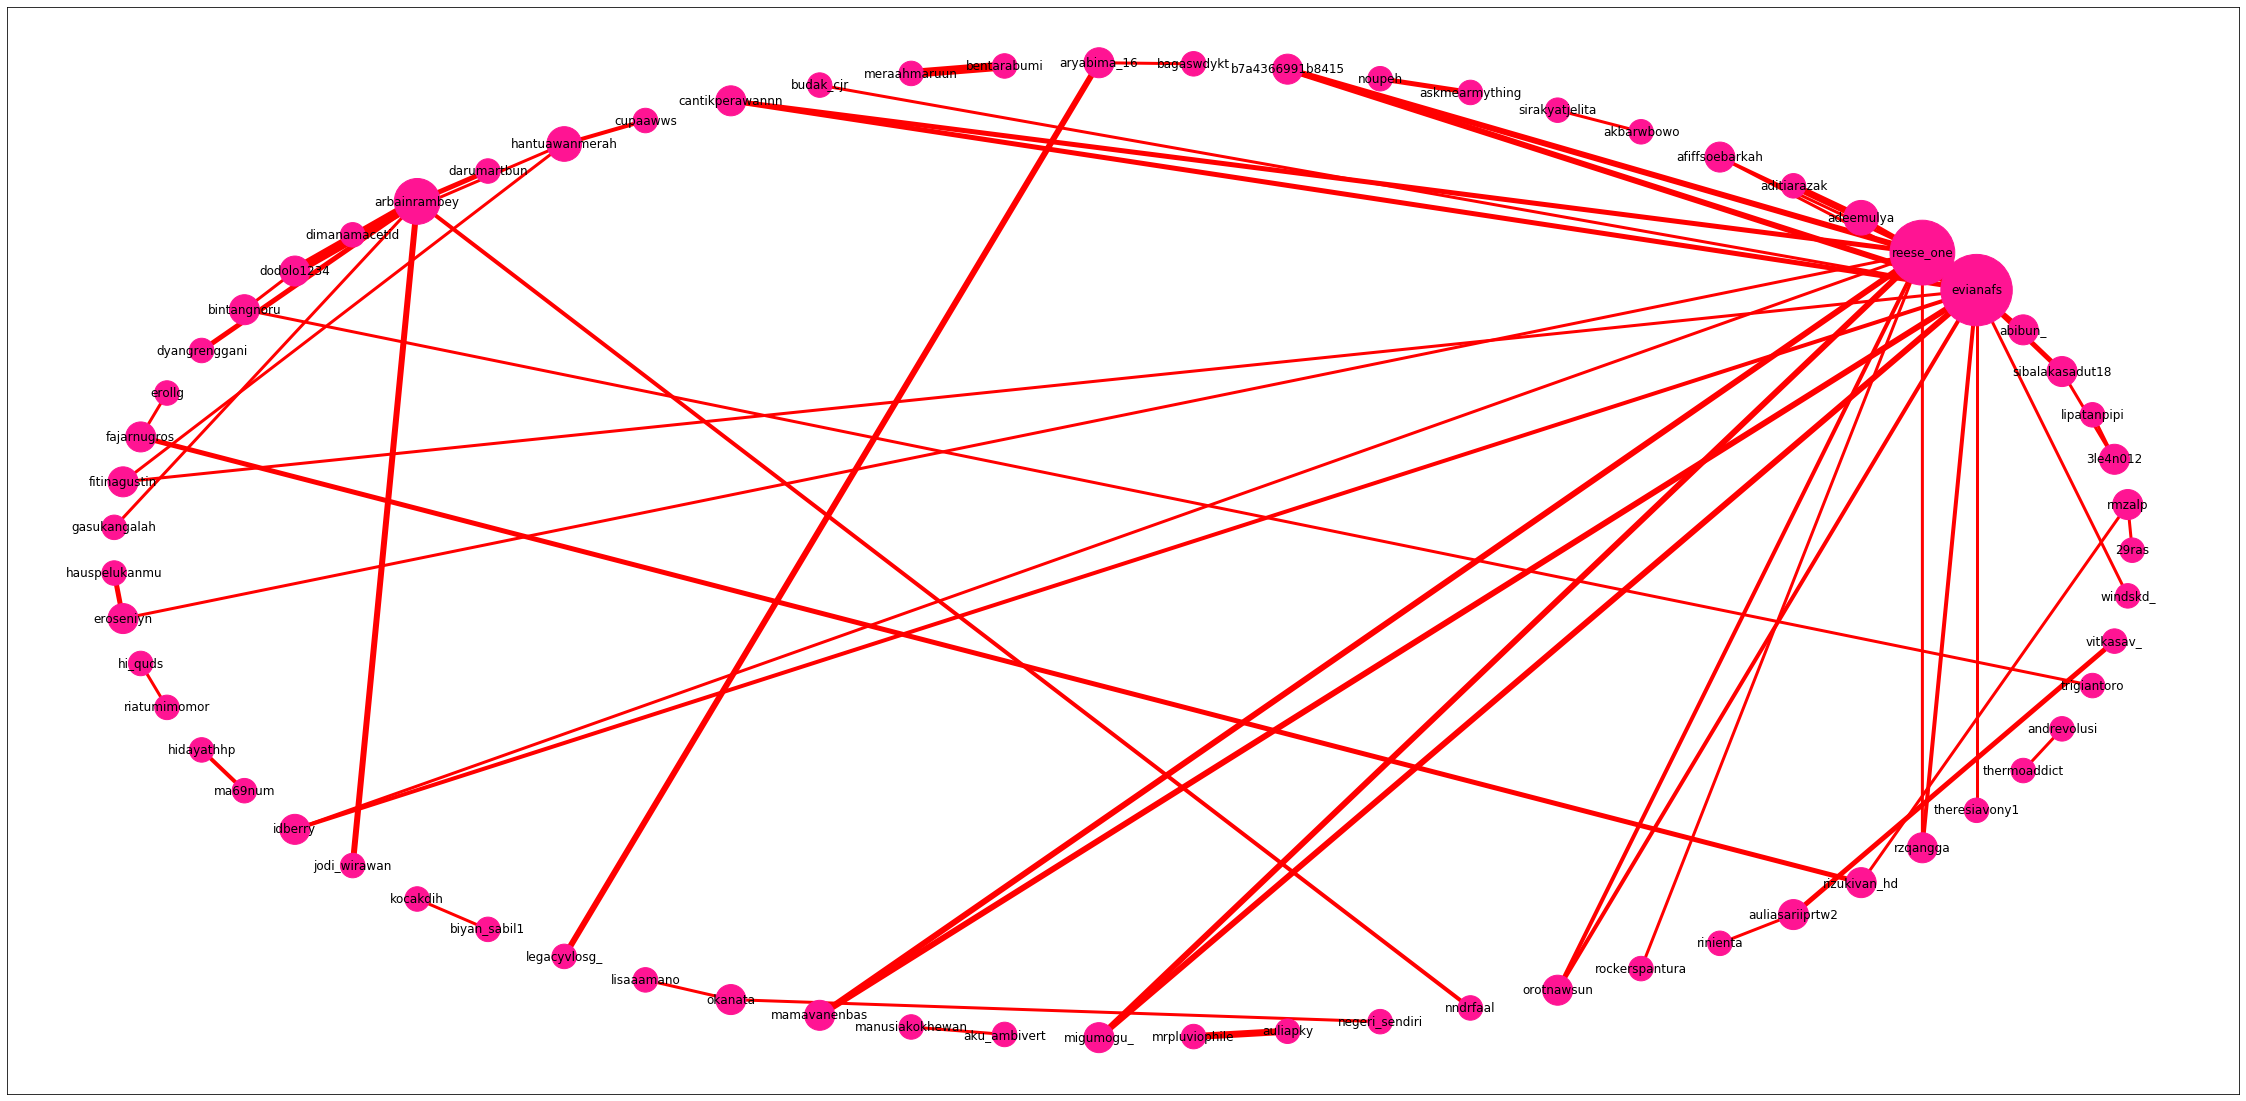

In [66]:
plt.figure(figsize=(40,20))
pos = nx.circular_layout(replyto_graph_data)
degrees = nx.degree(replyto_graph_data)
node_color = [replyto_graph_data.node[node]['color'] for node in replyto_graph_data]
node_size = [(degrees[v] + 1) * 300.0 for v in replyto_graph_data.nodes()]
edge_color = [replyto_graph_data[u][v]['color'] for u,v in replyto_graph_data.edges()]
edge_weight = [replyto_graph_data[u][v]['weight'] for u,v in replyto_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(replyto_graph_data, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)

Menampilkan 5 node dengan nilai degree terbesar

In [15]:
sorted(replyto_graph_data.degree, key=lambda x: x[1], reverse=True)[:5]

[('evianafs', 16),
 ('reese_one', 13),
 ('arbainrambey', 6),
 ('adeemulya', 3),
 ('hantuawanmerah', 3)]

Melakukan penggabungan data aktivitas secara keseluruhan

In [16]:
first_join = nx.Graph()
second_join = nx.Graph()
all_graph_data = nx.Graph()

In [17]:
first_join = nx.compose(mentions_graph_data, retweets_graph_data)
second_join = nx.compose(first_join, replyto_graph_data)

In [18]:
all_graph_data = second_join.copy()

Menyimpan data ke file graphml

In [307]:
nx.write_graphml(all_graph_data, "../data/interractions/all/all_data_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [171]:
all_graph_data = nx.read_graphml("../data/interractions/all/all_data_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

Menampilkan graph untuk memetakan interaksi reply_to pada pengguna

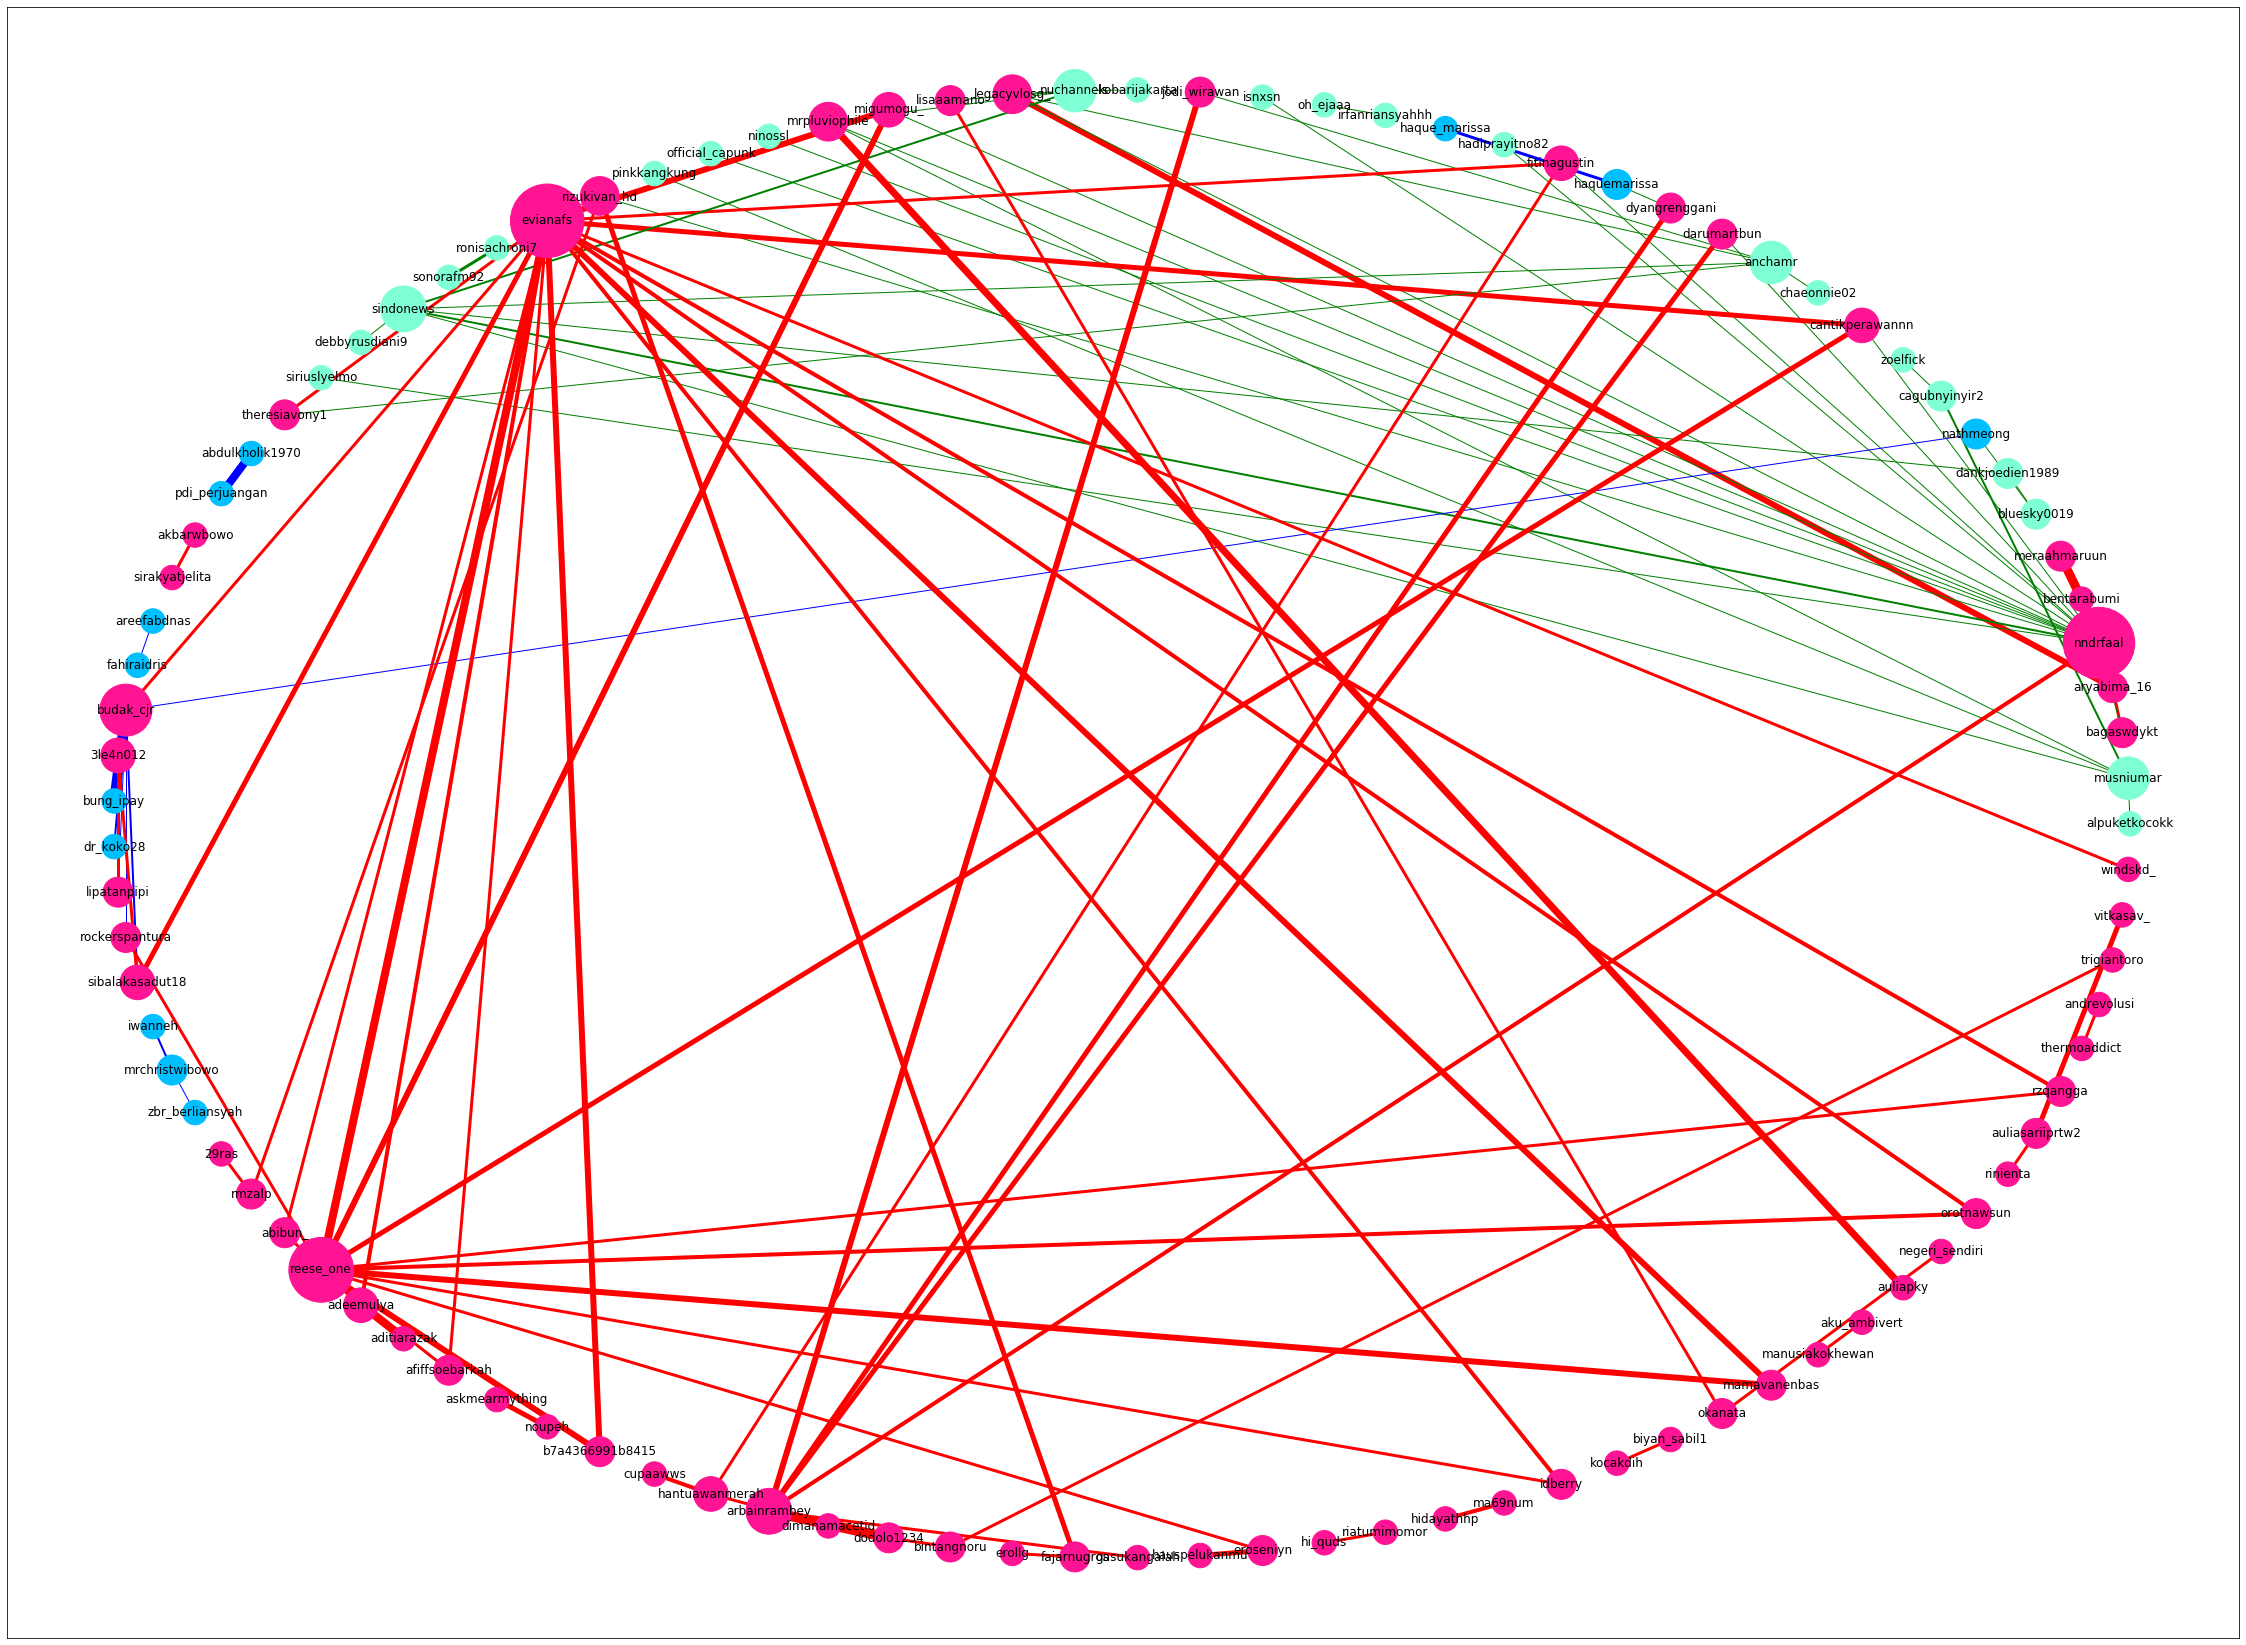

In [172]:
plt.figure(figsize=(40,30))
pos = nx.circular_layout(all_graph_data)
degrees = nx.degree(all_graph_data)
node_color = [all_graph_data.node[node]['color'] for node in all_graph_data]
node_size = [(degrees[v] + 1) * 300.0 for v in all_graph_data.nodes()]
edge_color = [all_graph_data[u][v]['color'] for u,v in all_graph_data.edges()]
edge_weight = [all_graph_data[u][v]['weight'] for u,v in all_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(all_graph_data, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)

**Melakukan seleksi node berdasarkan nilai degree**

In [19]:
def trim_degrees(g, degree):
    g2=g.copy()
    d=nx.degree(g2)
    list_g2 = list(g2.nodes)
    
    for n in list_g2:
        if d[n]<=degree: 
            g2.remove_node(n)
            
    return g2

In [20]:
selected_graph = trim_degrees(all_graph_data, 1)
print('Sisa node:', len(selected_graph), 'nodes')

Sisa node: 43 nodes


Menampilkan graph untuk memetakan interaksi reply_to pada pengguna

/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


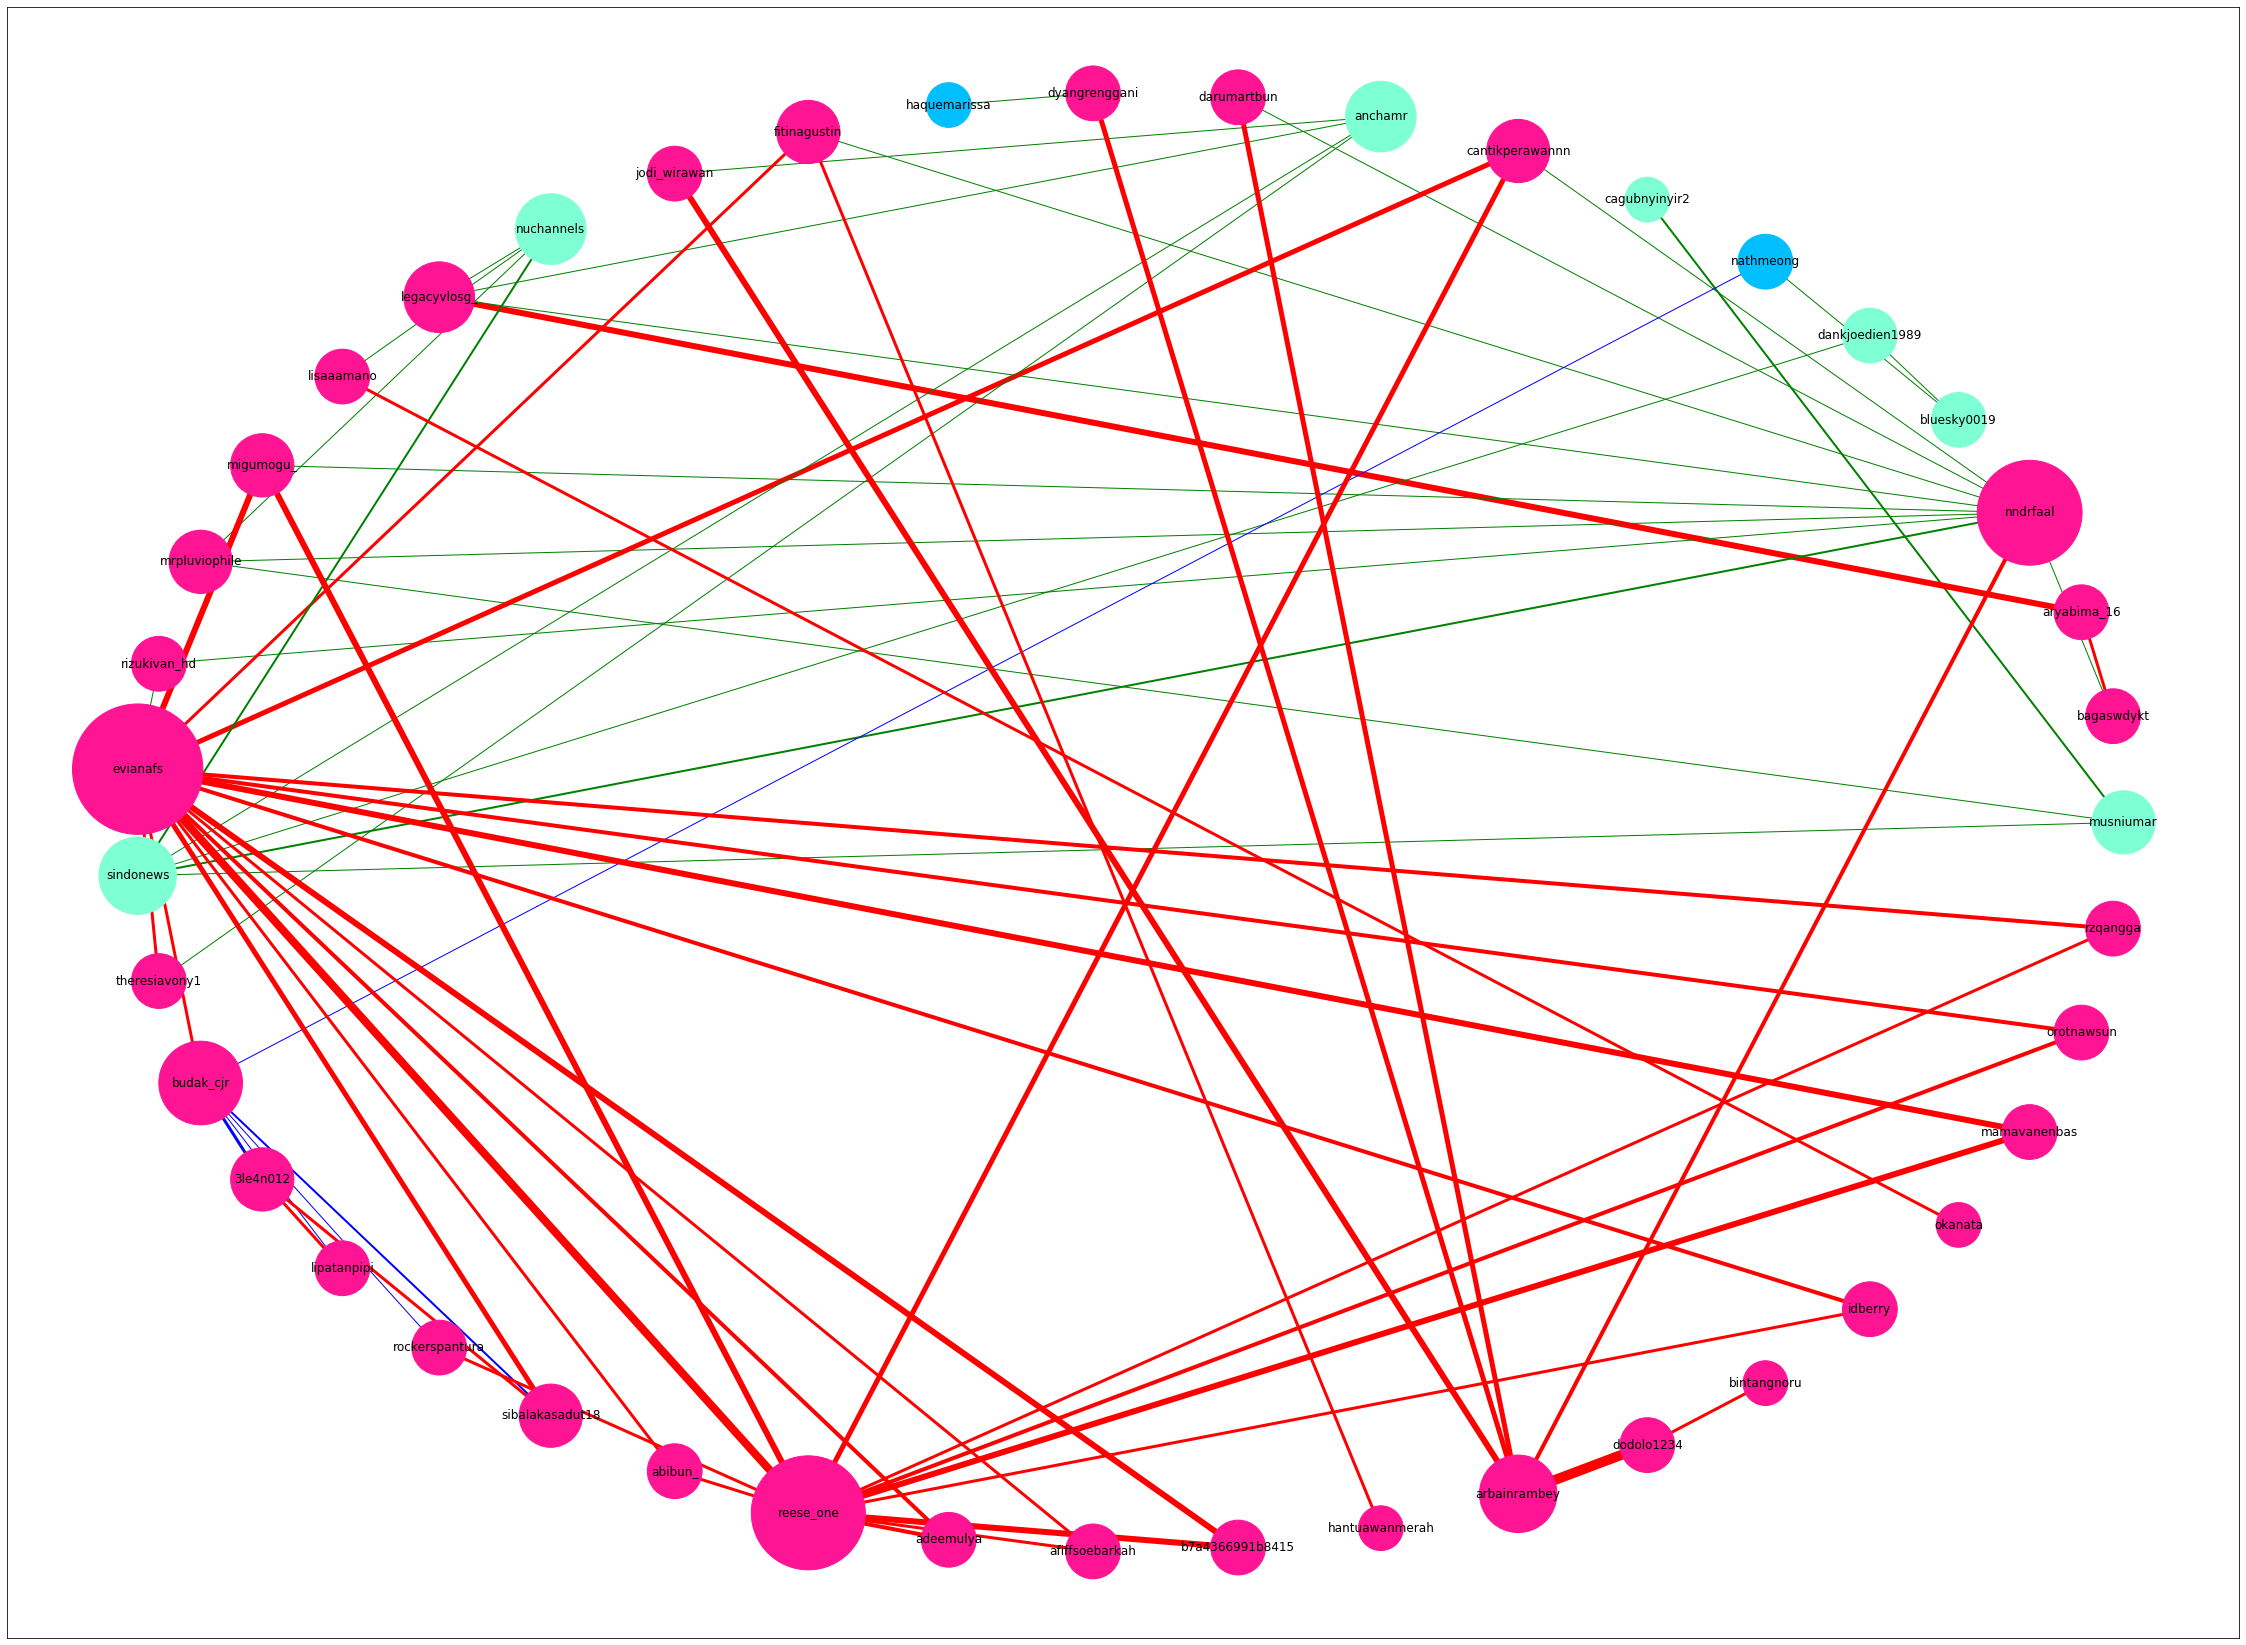

In [261]:
plt.figure(figsize=(40,30))
pos = nx.circular_layout(selected_graph)
degrees = nx.degree(selected_graph)
node_color = [selected_graph.node[node]['color'] for node in selected_graph]
node_size = [(degrees[v] + 1) * 1000.0 for v in selected_graph.nodes()]
edge_color = [selected_graph[u][v]['color'] for u,v in selected_graph.edges()]
edge_weight = [selected_graph[u][v]['weight'] for u,v in selected_graph.edges()]
edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(selected_graph, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)

**Melihat centralitas dari node**

In [270]:
specific_deg=nx.degree(selected_graph)
specific_deg['evianafs']

16

Mengurutkan node berdasarkan nilai degree tertinggi ke terendah

In [372]:
def sorted_map(map):
    ms = sorted(map.items(), key=lambda x: x[1], reverse=True)
    return ms

In [373]:
node_degree = nx.degree(selected_graph)
ds=sorted_map(dict(node_degree))

ds[0:9]

[('evianafs', 16),
 ('reese_one', 12),
 ('nndrfaal', 10),
 ('budak_cjr', 6),
 ('sindonews', 5),
 ('arbainrambey', 5),
 ('anchamr', 4),
 ('nuchannels', 4),
 ('legacyvlosg_', 4)]

**Menampilkan histogram data**

Melihat ditribusi centralitas dari semua nodes dengan histogram

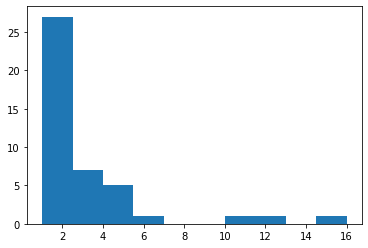

In [281]:
def plot_degree_dist(G):
    degrees = [selected_graph.degree(n) for n in selected_graph.nodes()]
    plt.hist(degrees)
    plt.show()

graph_dist = plot_degree_dist(nx.gnp_random_graph(100, 0.5, directed=True))

Melihat ditribusi centralitas dari semua nodes dengan log-log space histogram

In [282]:
def plot_degree_histogram(g, normalized=True, weight=None):
    
    degree_sequence = sorted([d for n, d in g.degree(weight=weight)], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    aux_x, aux_y = zip(*degreeCount.items())

    n_nodes = g.number_of_nodes()
    aux_y = list(aux_y)
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

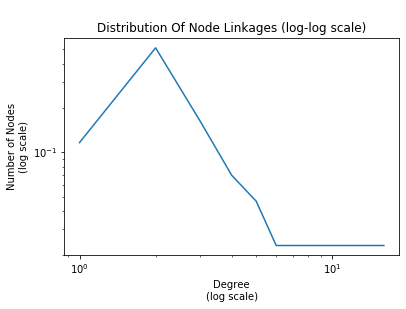

In [393]:
plotplot_hist = plot_degree_histogram(selected_graph)

plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
plt.plot(plotplot_hist[0], plotplot_hist[1])

**Membuat Snowball Sampling**

Membuat function untuk mendefenisikan queue

In [296]:
class Queue():
    # Constructor creates a list
    def __init__(self):
        self.queue = list()

    # Adding elements to queue
    def enqueue(self, data):
        # Checking to avoid duplicate entry (not mandatory)
        if data not in self.queue:
            self.queue.insert(0, data)
            return True
        return False

    # Removing the last element from the queue
    def dequeue(self):
        if len(self.queue) > 0:
            return self.queue.pop()
        else:
            # plt.show()
            exit()

    # Getting the size of the queue
    def size(self):
        return len(self.queue)

    # printing the elements of the queue
    def printQueue(self):
        return self.queue

Membuat function untuk menentukan snowball sampling

In [297]:
class Snowball():

    def __init__(self):
        self.G1 = nx.Graph()

    def snowball(self, G, size, k):
        q = Queue()
        list_nodes = list(G.nodes())
        m = k
        dictt = set()
        while(m):
            id = random.sample(list(G.nodes()), 1)[0]
            q.enqueue(id)
            m = m - 1
        # print(q.printQueue())
        while(len(self.G1.nodes()) <= size):
            if(q.size() > 0):
                id = q.dequeue()
                self.G1.add_node(id)
                if(id not in dictt):
                    dictt.add(id)
                    list_neighbors = list(G.neighbors(id))
                    if(len(list_neighbors) > k):
                        for x in list_neighbors[:k]:
                            q.enqueue(x)
                            self.G1.add_edge(id, x)
                    elif(len(list_neighbors) <= k and len(list_neighbors) > 0):
                        for x in list_neighbors:
                            q.enqueue(x)
                            self.G1.add_edge(id, x)
                else:
                    continue
            else:
                initial_nodes = random.sample(list(G.nodes()) and list(dictt), k)
                no_of_nodes = len(initial_nodes)
                for id in initial_nodes:
                    q.enqueue(id)
        return self.G1

Memanggil function snowball sampling

In [298]:
#make an object and call function SB
snowball_object = Snowball()
snowball_graph = snowball_object.snowball(selected_graph, 25, 5) # graph, number of nodes to sample , k set
print("Snowball Sampling:")
print("Number of nodes sampled=",len(snowball_graph.nodes()))
print("List of of nodes sampled=",(snowball_graph.nodes()))
print('')
print("Number of edges sampled=",len(snowball_graph.edges()))
print("List of edges sampled=",(snowball_graph.edges()))

Snowball Sampling:
Number of nodes sampled= 26
List of of nodes sampled= ['sibalakasadut18', 'evianafs', 'budak_cjr', '3le4n012', 'nndrfaal', 'bagaswdykt', 'cantikperawannn', 'darumartbun', 'fitinagustin', 'legacyvlosg_', 'mamavanenbas', 'reese_one', 'arbainrambey', 'dyangrenggani', 'jodi_wirawan', 'dodolo1234', 'rzqangga', 'migumogu_', 'rizukivan_hd', 'nathmeong', 'lipatanpipi', 'rockerspantura', 'aryabima_16', 'hantuawanmerah', 'anchamr', 'nuchannels']

Number of edges sampled= 33
List of edges sampled= [('sibalakasadut18', 'evianafs'), ('sibalakasadut18', 'budak_cjr'), ('sibalakasadut18', '3le4n012'), ('evianafs', 'mamavanenbas'), ('evianafs', 'rzqangga'), ('evianafs', 'cantikperawannn'), ('evianafs', 'fitinagustin'), ('evianafs', 'migumogu_'), ('evianafs', 'rizukivan_hd'), ('evianafs', 'budak_cjr'), ('budak_cjr', 'nathmeong'), ('budak_cjr', '3le4n012'), ('budak_cjr', 'lipatanpipi'), ('budak_cjr', 'rockerspantura'), ('3le4n012', 'lipatanpipi'), ('nndrfaal', 'bagaswdykt'), ('nndrfaal

Menampilkan graph untuk memetakan snowball sampling

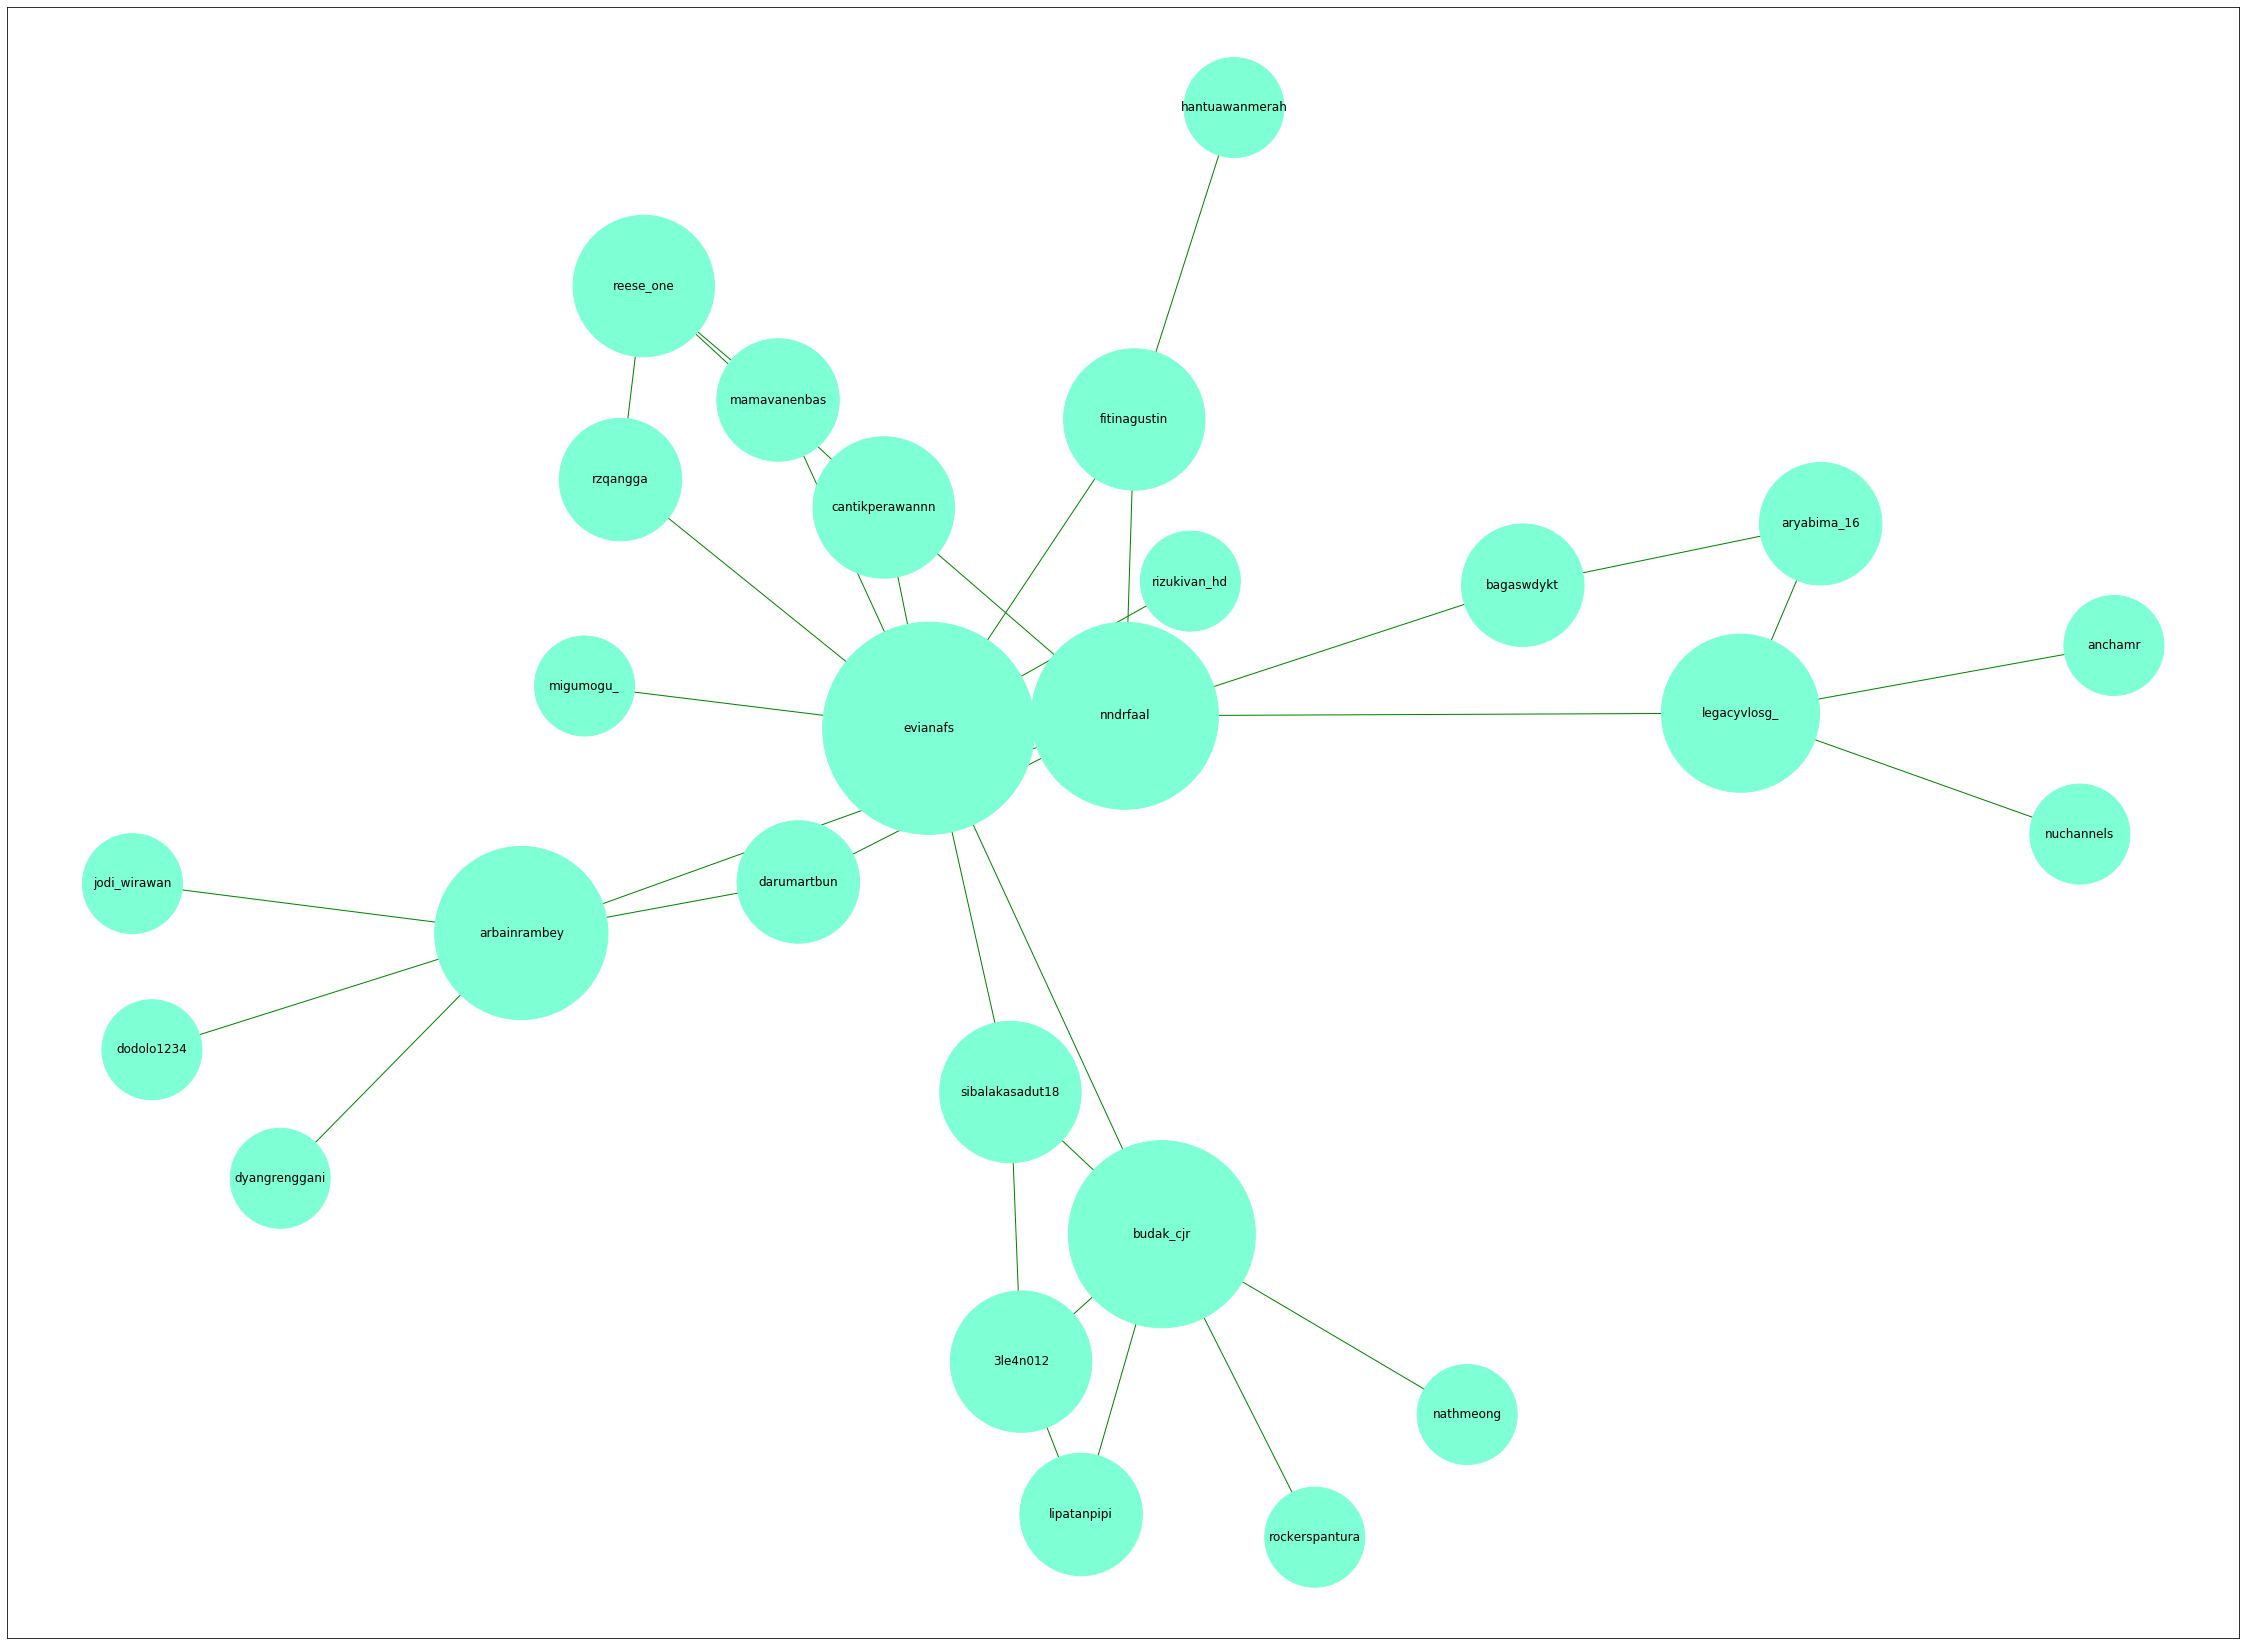

In [305]:
plt.figure(figsize=(40,30))
pos = nx.spring_layout(snowball_graph)
degrees = nx.degree(snowball_graph)
#node_color = [snowball_graph.node[node]['color'] for node in snowball_graph]
node_size = [(degrees[v] + 1) * 5000.0 for v in snowball_graph.nodes()]
#edge_color = [snowball_graph[u][v]['color'] for u,v in snowball_graph.edges()]
#edge_weight = [snowball_graph[u][v]['weight'] for u,v in snowball_graph.edges()]
#edge_discretization = discretization_weight(edge_weight)

nx.draw_networkx(snowball_graph, pos=pos, cmap=plt.cm.PiYG, node_size=node_size, node_color='#7FFFD4', edge_color='green')

**Menemukan node Gossipmongers**

Melihat data dengan 10 closeness centrality tertinggi

In [379]:
gossipmongers_nodes = nx.closeness_centrality(selected_graph)
sorted_gossipmongers_nodes=sorted_map(dict(gossipmongers_nodes))

sorted_gossipmongers_nodes[:11]

[('nndrfaal', 0.42424242424242425),
 ('evianafs', 0.40384615384615385),
 ('cantikperawannn', 0.39622641509433965),
 ('fitinagustin', 0.39622641509433965),
 ('migumogu_', 0.39622641509433965),
 ('rizukivan_hd', 0.3888888888888889),
 ('reese_one', 0.3652173913043478),
 ('theresiavony1', 0.3559322033898305),
 ('anchamr', 0.35294117647058826),
 ('sindonews', 0.35294117647058826),
 ('legacyvlosg_', 0.33070866141732286)]

Menampilkan graph untuk memetakan closeness centrality

(-0.40396292089256697,
 0.8023690640414192,
 -0.9632467063376783,
 1.11407643684056)

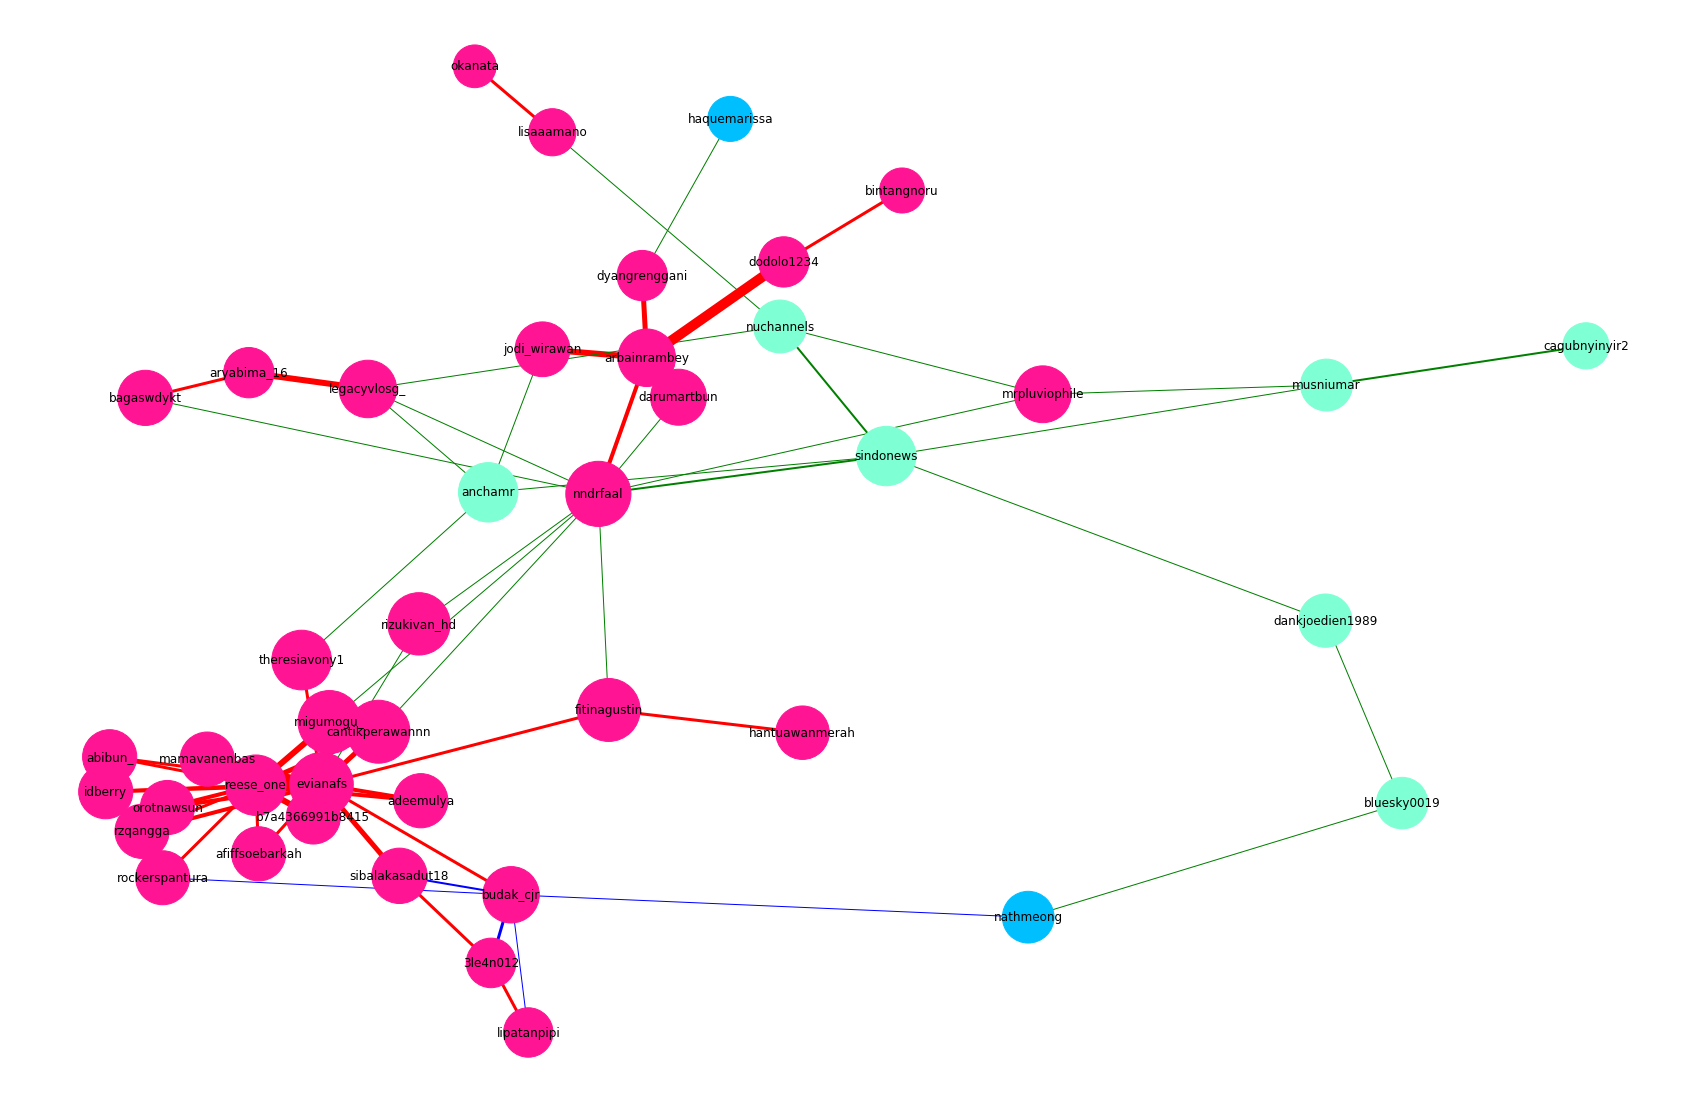

In [37]:
pos = nx.spring_layout(selected_graph)
closCent = nx.closeness_centrality(selected_graph)
node_color = [selected_graph.node[node]['color'] for node in selected_graph]
node_size = [v * 10000 for v in closCent.values()]
edge_color = [selected_graph[u][v]['color'] for u,v in selected_graph.edges()]
edge_weight = [selected_graph[u][v]['weight'] for u,v in selected_graph.edges()]
edge_discretization = discretization_weight(edge_weight)

plt.figure(figsize=(30,20))
nx.draw_networkx(selected_graph, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)
plt.axis('off')

**Menemukan Communication Bottlenecks dan Community Bridges**

Melihat data dengan 10 betweenness centrality tertinggi

In [382]:
betweenness_nodes = nx.betweenness_centrality(selected_graph)
sorted_betweenness_nodes=sorted_map(dict(betweenness_nodes))

sorted_betweenness_nodes[:11]

[('nndrfaal', 0.5087350641416102),
 ('evianafs', 0.4198068602829983),
 ('arbainrambey', 0.1935457109673137),
 ('sindonews', 0.16356886362751522),
 ('budak_cjr', 0.12894527277514817),
 ('reese_one', 0.11409916061484005),
 ('nuchannels', 0.09979298994978437),
 ('fitinagustin', 0.09967769116434513),
 ('cantikperawannn', 0.09928437561423516),
 ('migumogu_', 0.09928437561423516),
 ('legacyvlosg_', 0.0731795118254328)]

Menampilkan graph untuk memetakan betweenness centrality

(-0.8888062331969648,
 1.1000657047830418,
 -0.5350242966341175,
 0.879802941063616)

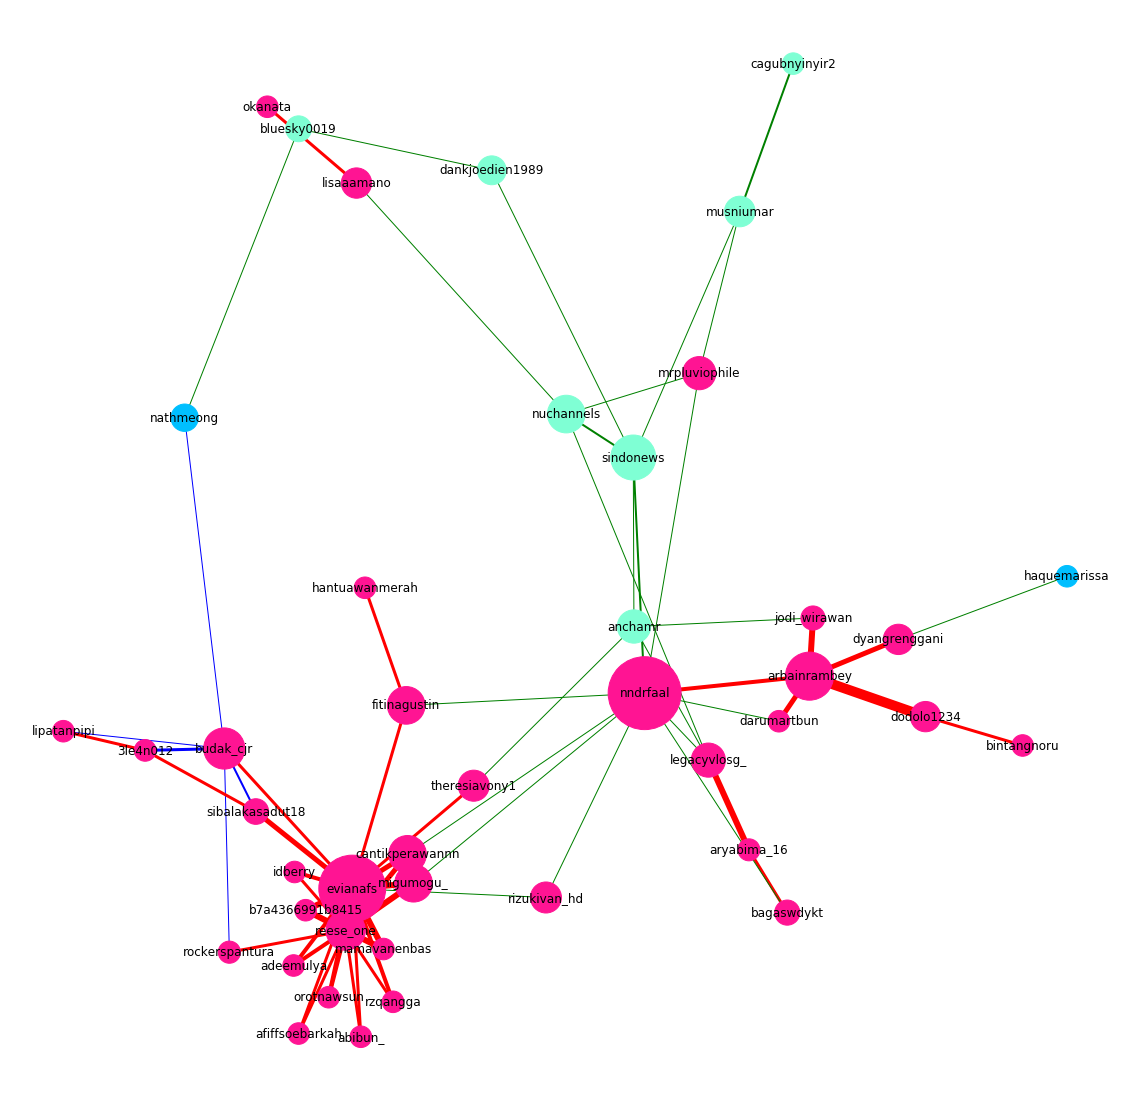

In [35]:
pos = nx.spring_layout(selected_graph)
betCent = nx.betweenness_centrality(selected_graph, normalized=True, endpoints=True)
node_color = [selected_graph.node[node]['color'] for node in selected_graph]
node_size =  [v * 10000 for v in betCent.values()]
edge_color = [selected_graph[u][v]['color'] for u,v in selected_graph.edges()]
edge_weight = [selected_graph[u][v]['weight'] for u,v in selected_graph.edges()]
edge_discretization = discretization_weight(edge_weight)

plt.figure(figsize=(20,20))
nx.draw_networkx(selected_graph, pos=pos, 
                 with_labels=True,
                 node_color=node_color,
                 node_size=node_size,
                 edge_color=edge_color, 
                 width=edge_discretization)
plt.axis('off')

**Menemukan Eigenvector Centrality**

Melihat data dengan 10 eigenvector centrality tertinggi

In [386]:
eigenvector_nodes = nx.eigenvector_centrality(selected_graph)
sorted_eigenvector_nodes=sorted_map(dict(eigenvector_nodes))

sorted_eigenvector_nodes[:11]

[('evianafs', 0.5406441789065599),
 ('reese_one', 0.4548606416695226),
 ('cantikperawannn', 0.21019878051323831),
 ('migumogu_', 0.21019878051323831),
 ('abibun_', 0.1800857834523518),
 ('adeemulya', 0.1800857834523518),
 ('afiffsoebarkah', 0.1800857834523518),
 ('b7a4366991b8415', 0.1800857834523518),
 ('idberry', 0.1800857834523518),
 ('mamavanenbas', 0.1800857834523518),
 ('orotnawsun', 0.1800857834523518)]

Menampilkan graph untuk memetakan eigenvector centrality

(-0.5865093523117728,
 0.7409659816192223,
 -1.0823305178512301,
 0.6684926398166247)

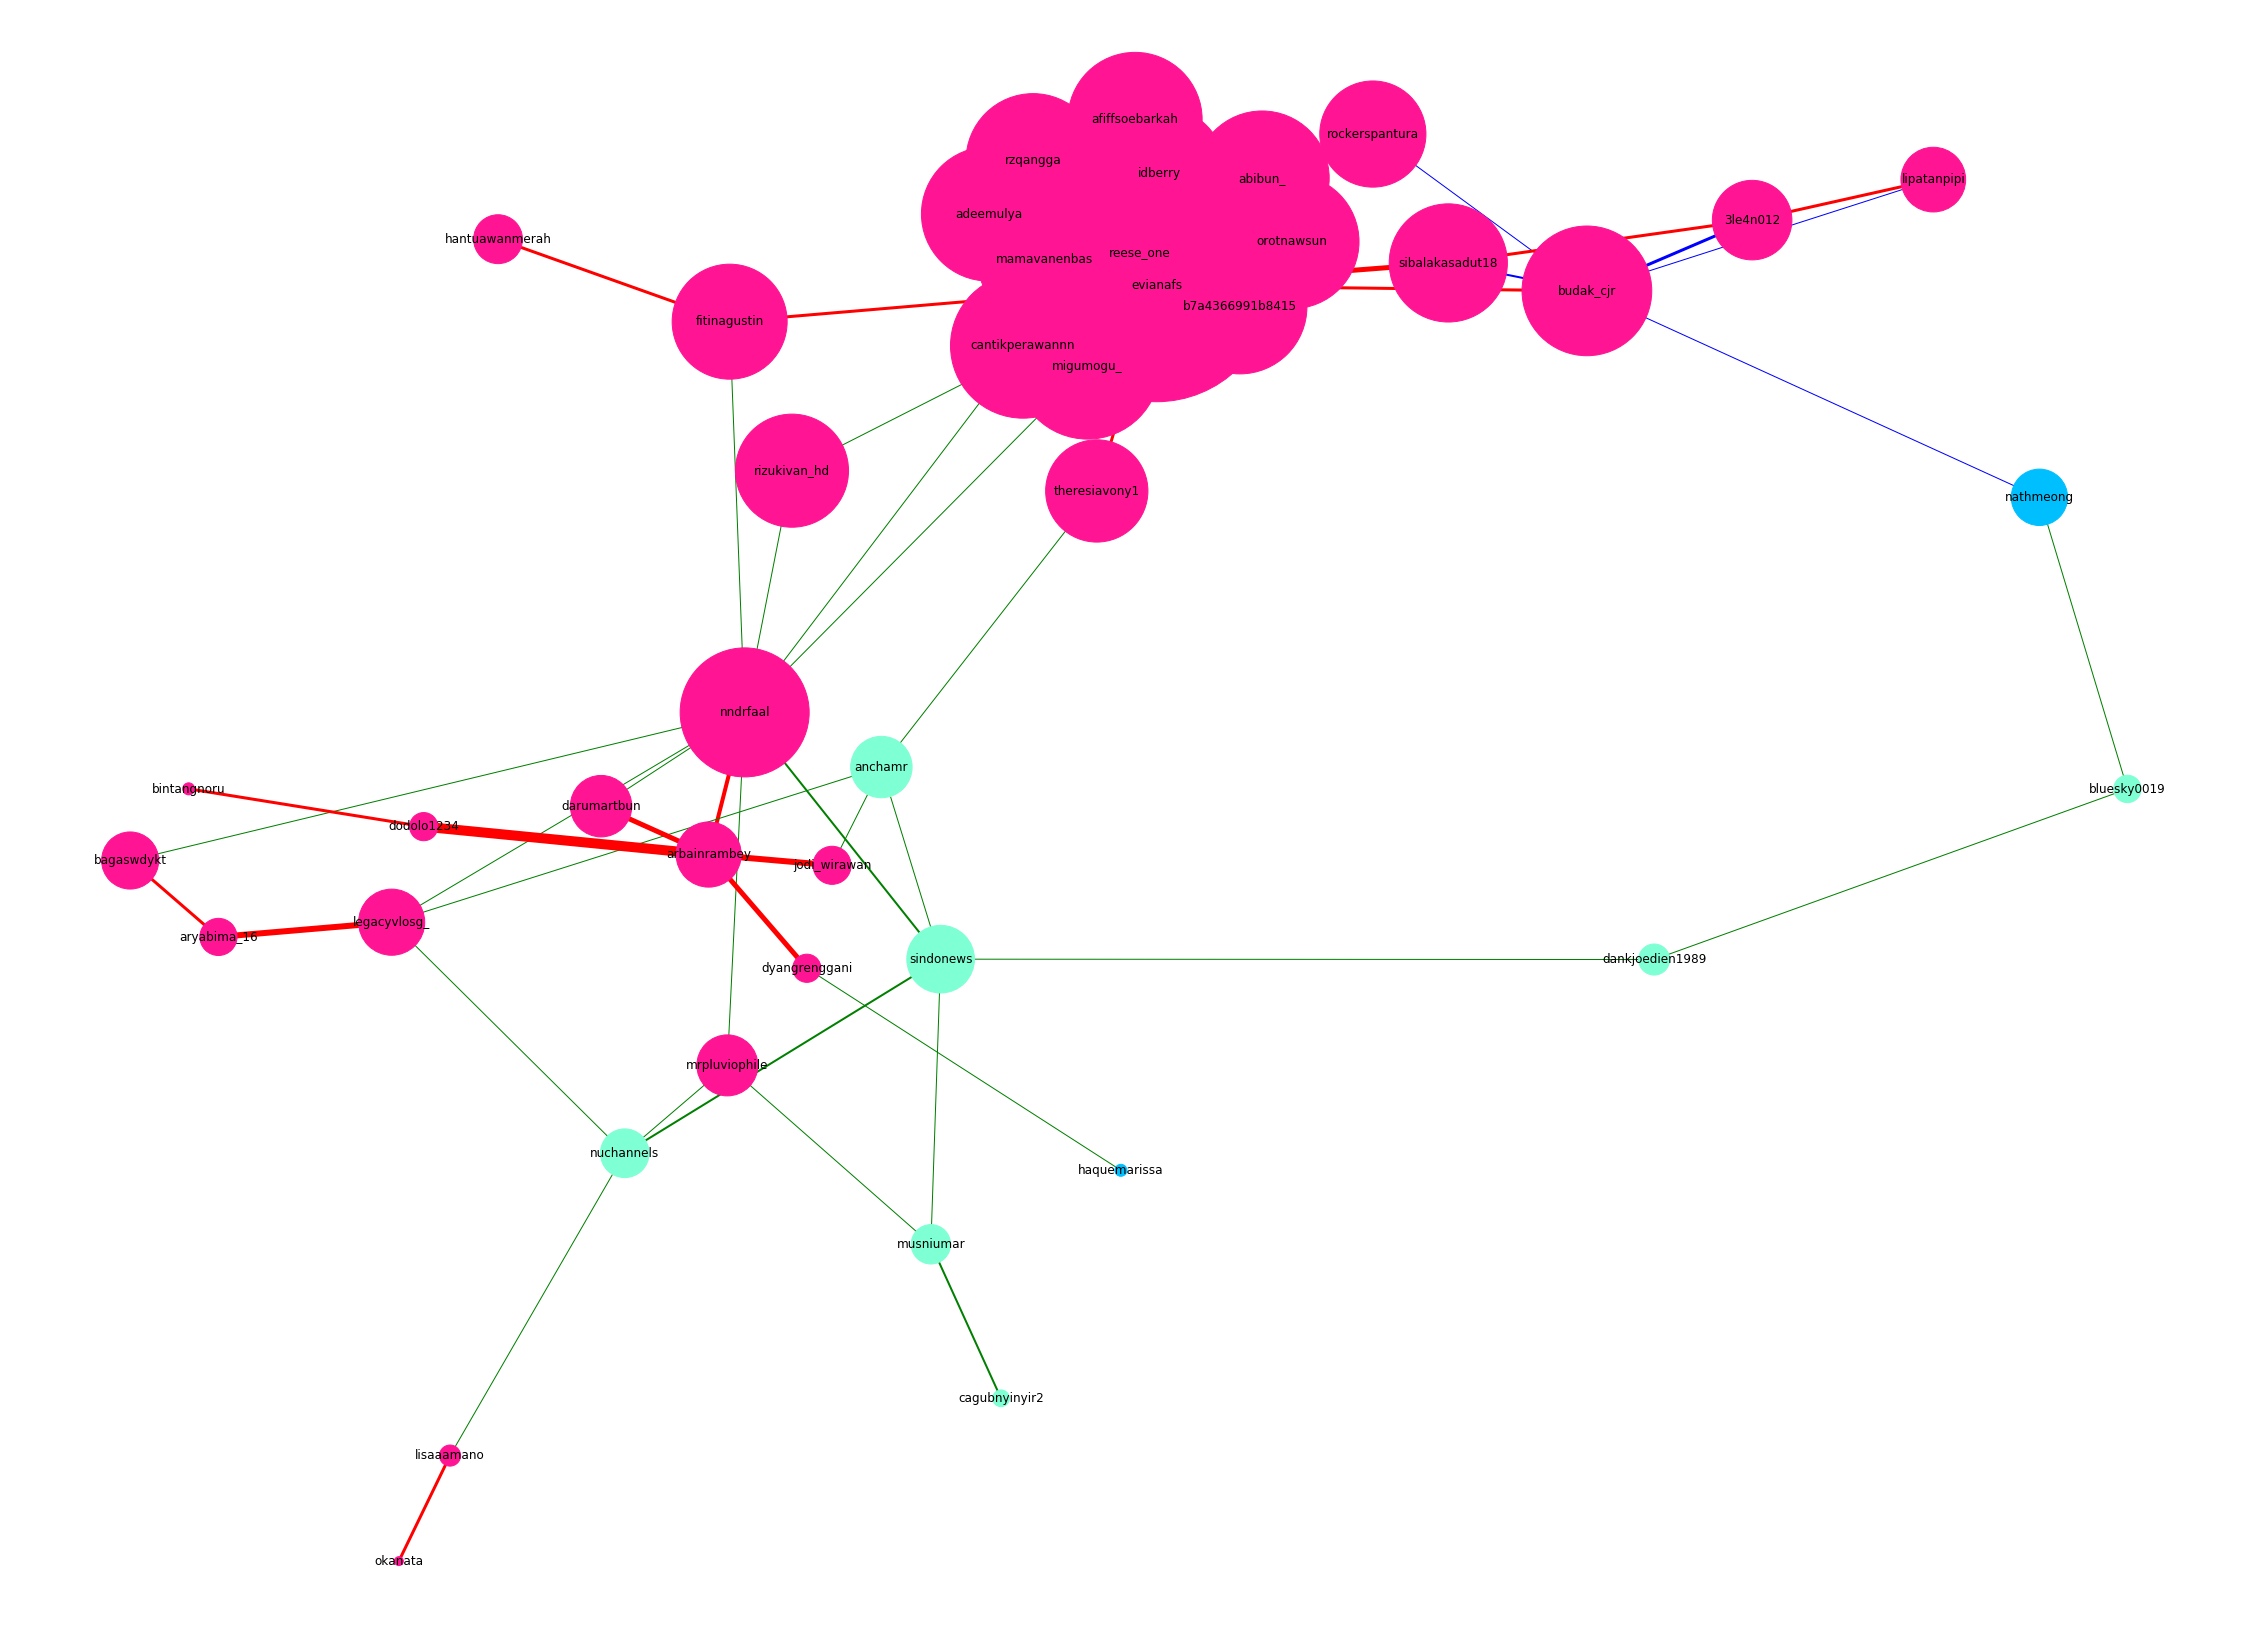

In [44]:
pos = nx.spring_layout(selected_graph)
betCent = nx.eigenvector_centrality(selected_graph)
degrees = nx.degree(selected_graph)
node_color = [selected_graph.node[node]['color'] for node in selected_graph]
node_size = [v * 100000 for v in betCent.values()]
edge_color = [selected_graph[u][v]['color'] for u,v in selected_graph.edges()]
edge_weight = [selected_graph[u][v]['weight'] for u,v in selected_graph.edges()]
edge_discretization = discretization_weight(edge_weight)

plt.figure(figsize=(40,30))
nx.draw_networkx(selected_graph, pos=pos, cmap=plt.cm.PiYG, node_color=node_color, node_size=node_size, edge_color=edge_color, width=edge_discretization)
plt.axis('off')

**Melihat Interaksi Pengguna dalam satuan Per-Minggu**

Membuat tambahan edge graph untuk memetakan jumlah postingan pengguna setiap minggunya

In [178]:
user_graph_data = set(selected_graph.nodes())

week_graph_data = selected_graph.copy()

for i, user in users_df.iterrows():
    if user['username'] in user_graph_data:
        for i in range(0, 27):
            node_name = '{}_minggu{}'.format(user['username'],i+1)
            column = 'minggu{}'.format(i+1)
            week_interactions_data = final_week_tweets.loc[[user['username']], [column]]
            week_interactions_value = week_interactions_data[column][0]
            
            #check jika kedua user punya interaksi
            if week_interactions_value > 10:
                week_graph_data.add_node(node_name, weight=week_interactions_value, color='#FFD700')
                week_graph_data.add_edge(user['username'],node_name, weight=week_interactions_value, color='#FFA500')

Menyalin graph data jumlah postingan

In [163]:
week_interaction_graph_data = week_graph_data.copy()

Menyimpan data ke file graphml

In [165]:
nx.write_graphml(week_interaction_graph_data, "../data/interractions/all/week_interaction_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [177]:
#week_interaction_graph_data = nx.read_graphml("../data/interractions/all/week_interaction_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

Menampilkan ke dalam bentuk grapik

(-0.7701744338884607,
 0.5858703753366724,
 -0.7118581219770977,
 1.0893847628691267)

<Figure size 1440x1440 with 0 Axes>

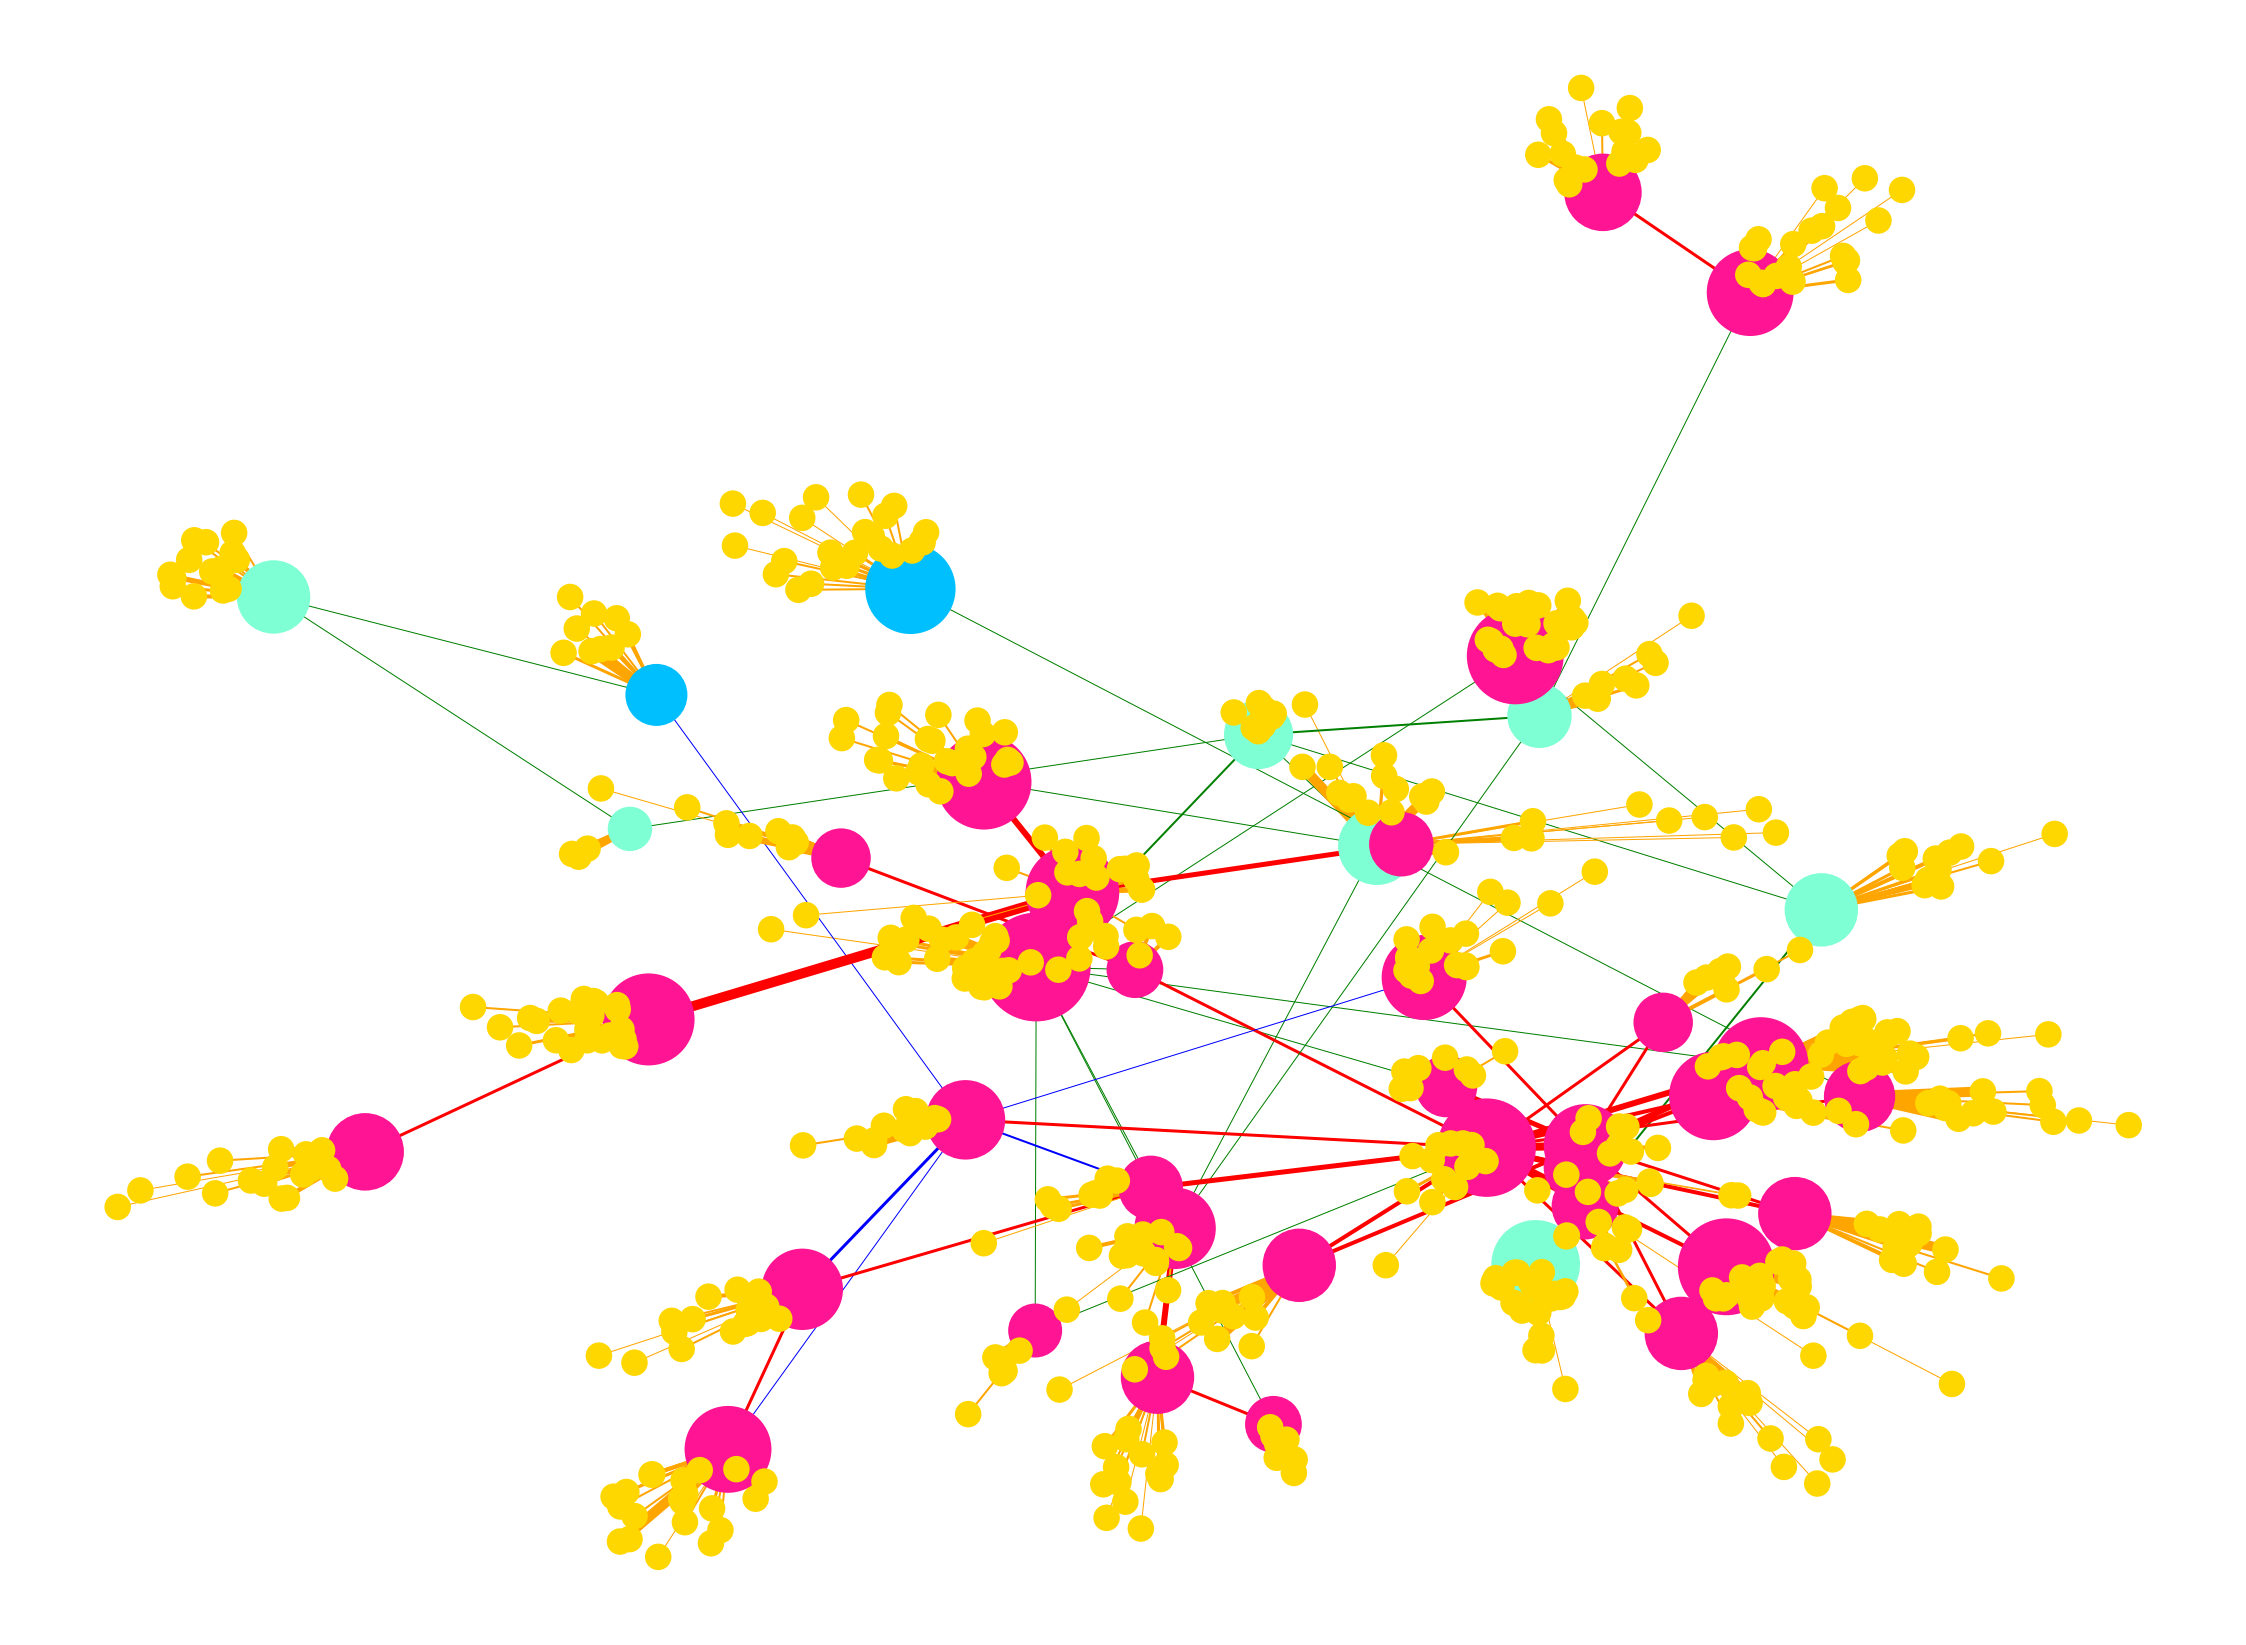

In [179]:
plt.figure(figsize = (20,20))
pos = nx.spring_layout(week_graph_data)
node_color = [week_graph_data.node[node]['color'] for node in week_graph_data]
degrees = nx.degree(week_graph_data)
node_size = [(degrees[v] + 1) * 300.0 for v in week_graph_data.nodes()]
edge_color = [week_graph_data[u][v]['color'] for u,v in week_graph_data.edges()]
edge_weight = [week_graph_data[u][v]['weight'] for u,v in week_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

plt.figure(figsize=(40,30))
nx.draw_networkx(week_graph_data, pos=pos, 
                 linewidths=2, cmap=plt.cm.PiYG, 
                 node_color=node_color, node_size=node_size, 
                 edge_color=edge_color, width=edge_discretization, with_labels=False, prog = 'dot')
plt.axis('off')

**Melihat Interaksi Pengguna dalam satuan Per-Bulan**

Membuat tambahan edge graph untuk memetakan jumlah postingan pengguna setiap bulannya

In [180]:
user_graph_data = set(selected_graph.nodes())

month_graph_data = selected_graph.copy()

for i, user in users_df.iterrows():
    if user['username'] in user_graph_data:
        for i in range(0, 7):
            node_name = '{}_bulan{}'.format(user['username'],i+1)
            column = 'bulan{}'.format(i+1)
            month_interactions_data = final_month_tweets.loc[[user['username']], [column]]
            month_interactions_value = month_interactions_data[column][0]
            
            #check jika kedua user punya interaksi
            if month_interactions_value > 50:
                month_graph_data.add_node(node_name, weight=month_interactions_value, color='#9370DB')
                month_graph_data.add_edge(user['username'],node_name, weight=month_interactions_value, color='#BA55D3')

Menyalin graph data jumlah postingan

In [173]:
month_interactions_graph_data_final = month_graph_data.copy()

Menyimpan data ke file graphml

In [174]:
nx.write_graphml(month_interactions_graph_data_final, "../data/interractions/all/month_interaction_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

membaca data file graph

In [176]:
#month_interactions_graph_data_final = nx.read_graphml("../data/interractions/all/month_interaction_graphml_{}-{}.graphml".format(date_start_convert, date_end_convert))  

Menampilkan ke dalam bentuk grapik

(-1.0994157843791976,
 0.9670128914496398,
 -0.8162667522428645,
 0.8512060628505466)

<Figure size 1440x1440 with 0 Axes>

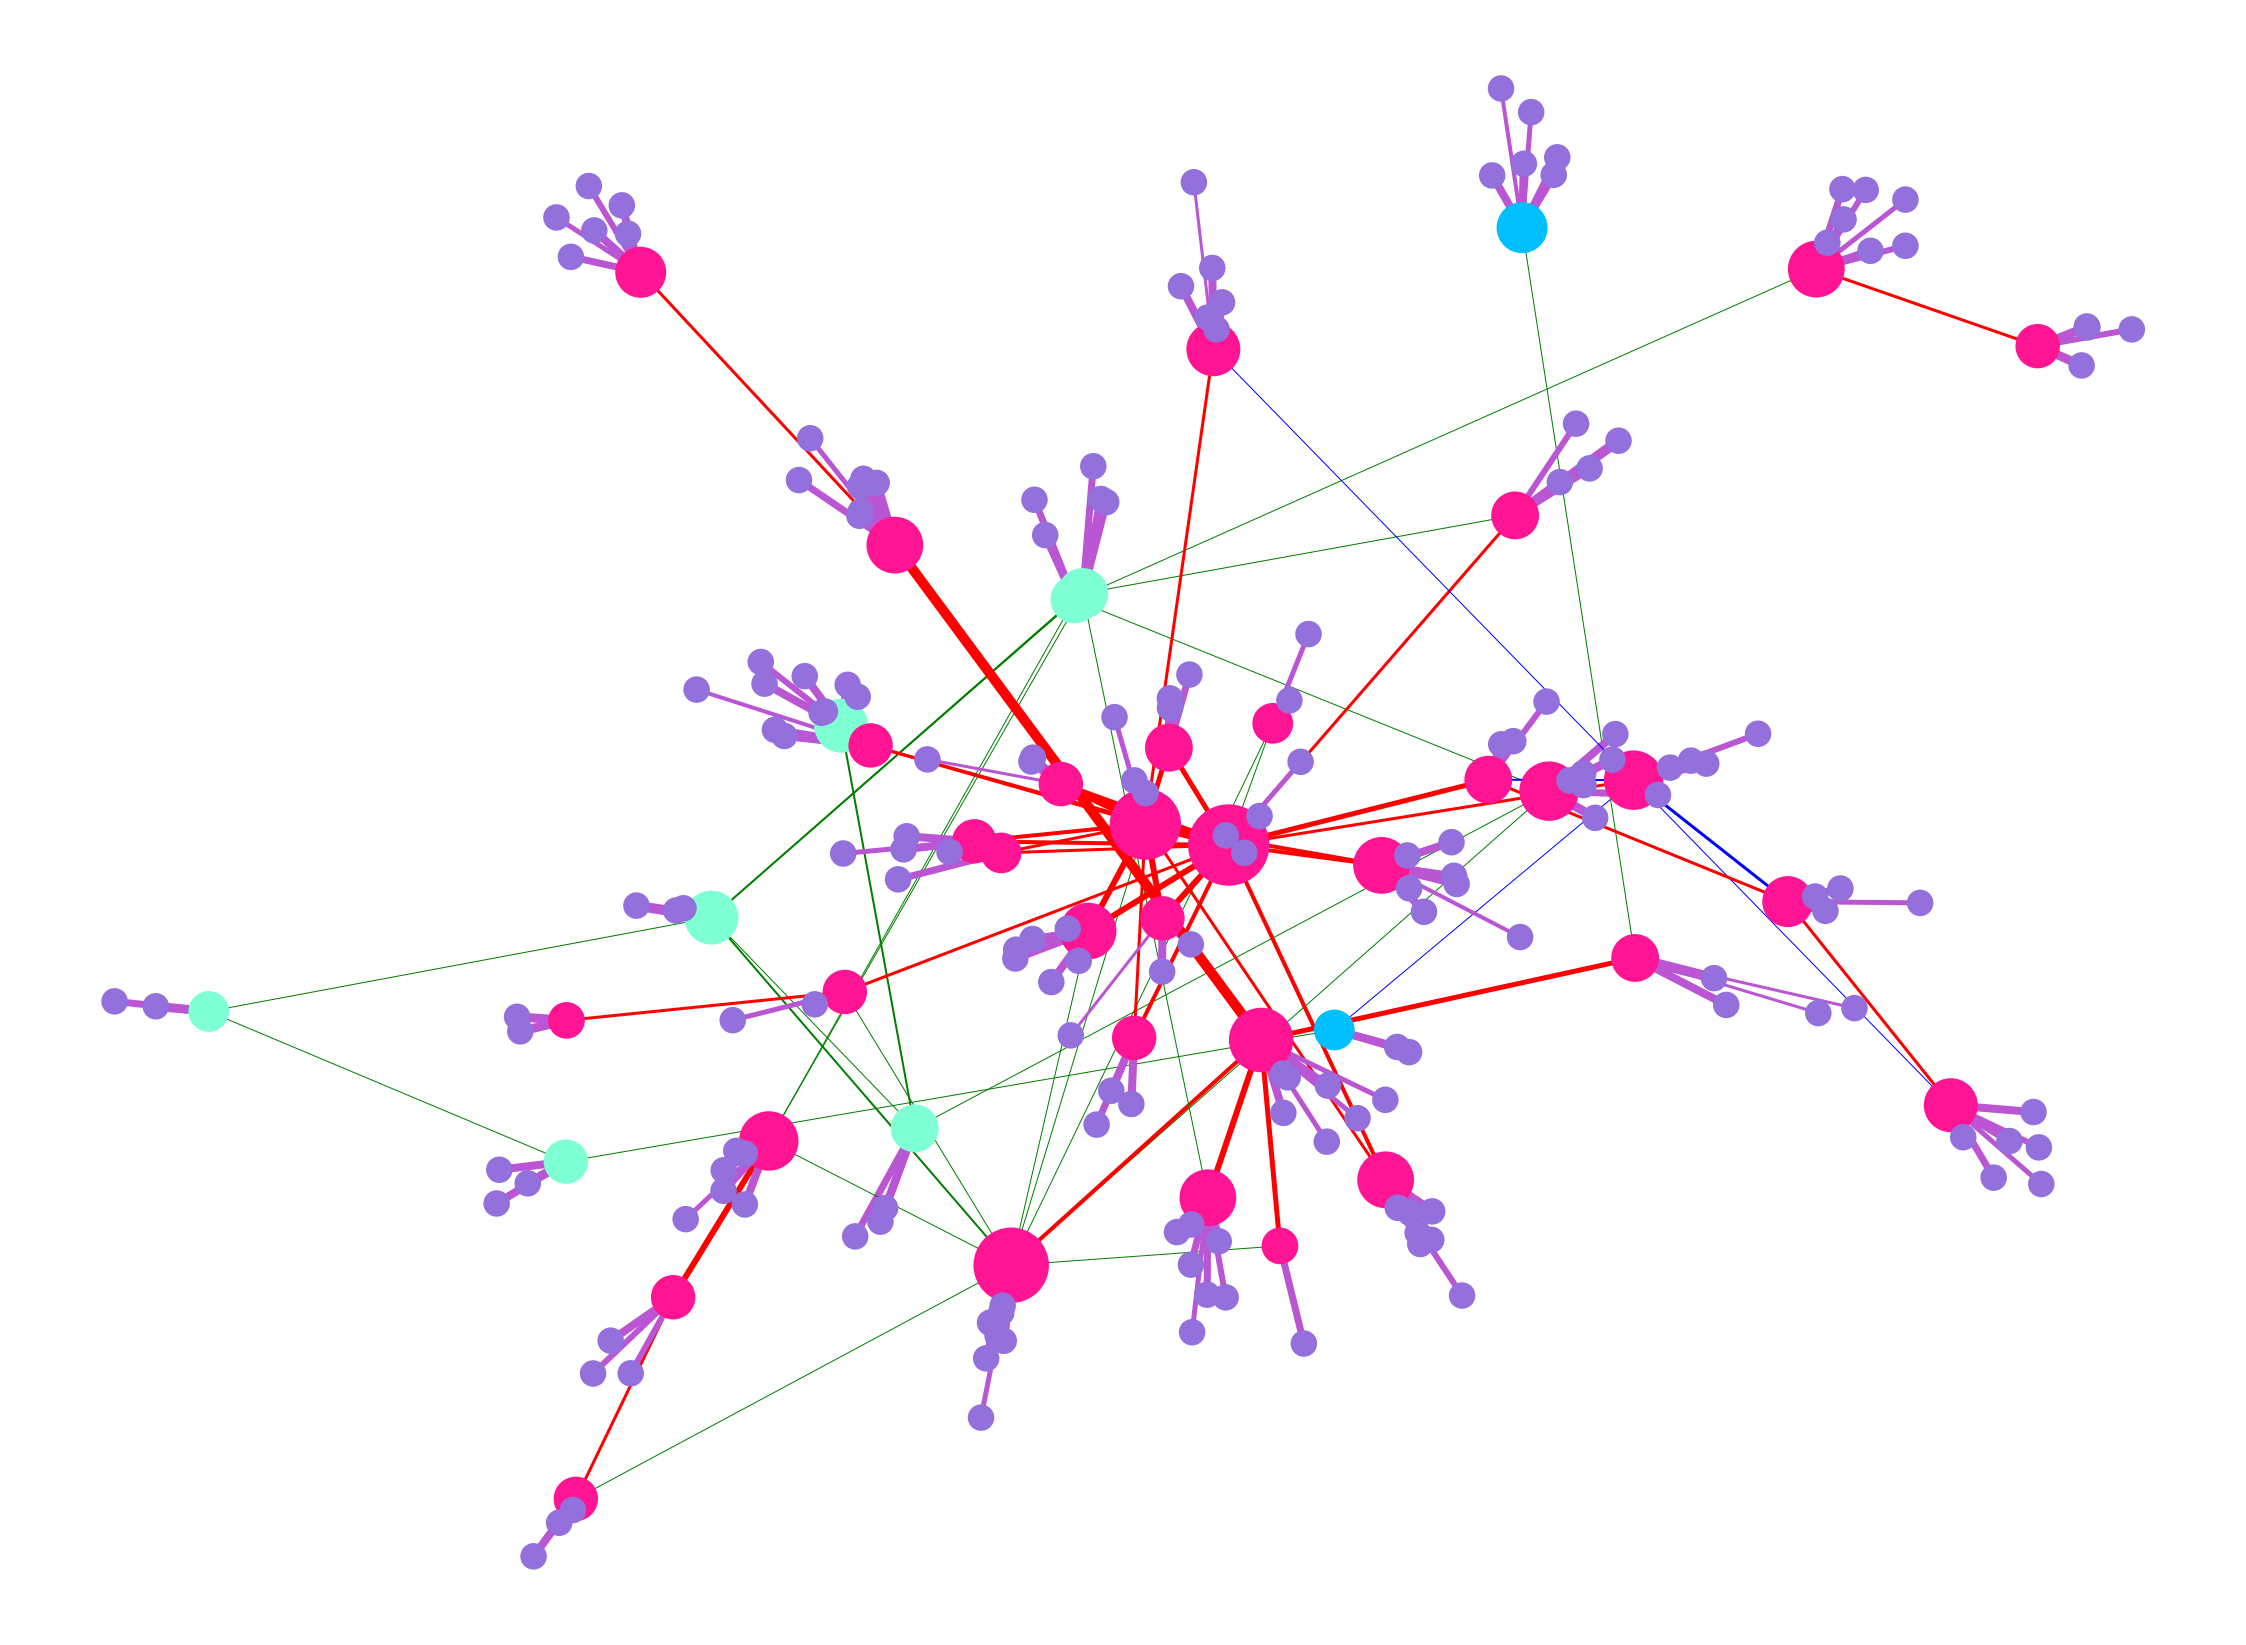

In [181]:
plt.figure(figsize = (20,20))
pos = nx.spring_layout(month_graph_data)
node_color = [month_graph_data.node[node]['color'] for node in month_graph_data]
degrees = nx.degree(month_graph_data)
node_size = [(degrees[v] + 1) * 300.0 for v in month_graph_data.nodes()]
edge_color = [month_graph_data[u][v]['color'] for u,v in month_graph_data.edges()]
edge_weight = [month_graph_data[u][v]['weight'] for u,v in month_graph_data.edges()]
edge_discretization = discretization_weight(edge_weight)

plt.figure(figsize=(40,30))
nx.draw_networkx(month_graph_data, pos=pos, 
                 linewidths=2, cmap=plt.cm.PiYG, 
                 node_color=node_color, node_size=node_size, 
                 edge_color=edge_color, width=edge_discretization, with_labels=False, prog = 'dot')
plt.axis('off')